# seg_lambda=0.3, alpha=0.5000

## 1. Paths & Training Hyperparameters

In [1]:
import os, sys, math, time, random, itertools
from typing import Tuple, List, Dict
import timm

IMG_ROOT = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images"
TRAIN_CSV = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_train_images.csv"
TEST_CSV  = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_test_images.csv"
MASK_ROOT = IMG_ROOT.replace("png_images", "png_masks")  

OUT_DIR   = "./ConvNeXt+UNet(8,1,1)_base7_Output"

IMG_SIZE  = 576  
EPOCHS    = 120       
BATCH     = 4         
LR        = 2e-4
SEED      = 42
VAL_RATIO = 0.20       
SAMPLER   = "off"  

print("IMG_ROOT:", IMG_ROOT)
print("TRAIN_CSV:", TRAIN_CSV)
print("TEST_CSV:", TEST_CSV)
print("OUT_DIR:", OUT_DIR)
print("EPOCHS/BATCH/LR:", EPOCHS, BATCH, LR)
print("VAL_RATIO/SAMPLER:", VAL_RATIO, SAMPLER)

IMG_ROOT: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images
TRAIN_CSV: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_train_images.csv
TEST_CSV: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_test_images.csv
OUT_DIR: ./ConvNeXt+UNet(8,1,1)_base7_Output
EPOCHS/BATCH/LR: 120 4 0.0002
VAL_RATIO/SAMPLER: 0.2 off


## 2. Imports & Device

In [2]:
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler, WeightedRandomSampler
from torchvision import transforms
from torchvision.transforms import functional as TF
from torchvision.transforms import InterpolationMode
import torchvision

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score,
                             confusion_matrix, roc_curve, precision_recall_curve)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({"figure.dpi": 110})

def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(SEED)
print(f"Using device: {device} | AMP: {'on' if device.type=='cuda' else 'off'}")

Using device: cuda | AMP: on


In [3]:
class BalancedBatchSampler(Sampler):
    def __init__(self, labels, batch_size, pos_label=1, neg_label=0, drop_last=True):
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.pos_label = pos_label
        self.neg_label = neg_label
        self.drop_last = drop_last

        assert batch_size % 2 == 0, "BalancedBatchSampler: batch_size 必须为偶数才能 1:1 采样"

        self.half_bs = batch_size // 2 

        self.pos_indices = np.where(self.labels == self.pos_label)[0]
        self.neg_indices = np.where(self.labels == self.neg_label)[0]

        if len(self.pos_indices) == 0 or len(self.neg_indices) == 0:
            raise ValueError("BalancedBatchSampler: 数据集中某个类别为 0，无法做平衡 batch")

    def __len__(self):
        min_class_num = min(len(self.pos_indices), len(self.neg_indices))
        num_batches = min_class_num // self.half_bs
        if not self.drop_last and min_class_num % self.half_bs != 0:
            num_batches += 1
        return num_batches

    def __iter__(self):
        pos_indices = np.random.permutation(self.pos_indices)
        neg_indices = np.random.permutation(self.neg_indices)

        max_len = max(len(pos_indices), len(neg_indices))
        if len(pos_indices) < max_len:
            repeat = int(np.ceil(max_len / len(pos_indices)))
            pos_indices = np.tile(pos_indices, repeat)[:max_len]
        if len(neg_indices) < max_len:
            repeat = int(np.ceil(max_len / len(neg_indices)))
            neg_indices = np.tile(neg_indices, repeat)[:max_len]

        pos_ptr, neg_ptr = 0, 0
        num_batches = len(self)

        for _ in range(num_batches):
            batch_pos = pos_indices[pos_ptr:pos_ptr + self.half_bs]
            batch_neg = neg_indices[neg_ptr:neg_ptr + self.half_bs]
            pos_ptr += self.half_bs
            neg_ptr += self.half_bs

            batch_idx = np.concatenate([batch_pos, batch_neg])
            np.random.shuffle(batch_idx)

            yield batch_idx.tolist()

## 3. Read CSVs & Quick Preview

In [4]:
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

display(train_df.head(8))
display(test_df.head(8))

print("Train shape:", train_df.shape, "Columns:", list(train_df.columns))
print("Test  shape:", test_df.shape, "Columns:", list(test_df.columns))

print("Train label distribution:", train_df["has_pneumo"].value_counts().to_dict())
print("Test  label distribution:", test_df["has_pneumo"].value_counts().to_dict())

,new_filename,ImageId,has_pneumo
0,0_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,0
1,1_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,0
2,2_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,1
3,3_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,1
4,4_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.1314.151787516...,1
5,5_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.11364.15178752...,0
6,6_train_0_.png,1.2.276.0.7230010.3.1.4.8323329.4541.151787518...,0
7,7_train_1_.png,1.2.276.0.7230010.3.1.4.8323329.4440.151787518...,1


,new_filename,ImageId,has_pneumo
0,0_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5797.151787519...,1
1,1_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5798.151787519...,0
2,2_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5799.151787519...,0
3,3_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.580.1517875163...,0
4,4_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5800.151787519...,0
5,5_test_0_.png,1.2.276.0.7230010.3.1.4.8323329.5801.151787519...,0
6,6_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5802.151787519...,1
7,7_test_1_.png,1.2.276.0.7230010.3.1.4.8323329.5803.151787519...,1


Train shape: (10675, 3) Columns: ['new_filename', 'ImageId', 'has_pneumo']
Test  shape: (1372, 3) Columns: ['new_filename', 'ImageId', 'has_pneumo']
Train label distribution: {0: 8296, 1: 2379}
Test  label distribution: {0: 1082, 1: 290}


## 4. Full-path Resolution & Dataset 

In [5]:
# Dataset-wise normalization stats (from pixel intensity histogram)
IMG_MEAN = 119.6 / 255.0   # ≈ 0.4690
IMG_STD  = 62.0  / 255.0   # ≈ 0.2431
print(f"Using normalization mean={IMG_MEAN:.4f}, std={IMG_STD:.4f}")

def resolve_full_paths(df: pd.DataFrame, img_root: str) -> pd.DataFrame:
    df = df.copy()
    def _resolve(row):
        name = str(row["new_filename"])
        name_png = name if name.lower().endswith(".png") else f"{name}.png"
        p1 = os.path.join(img_root, name_png)
        if os.path.exists(p1):
            return p1
        # fallback: ImageId.png
        alt = os.path.join(img_root, f"{row['ImageId']}.png")
        return alt if os.path.exists(alt) else p1
    df["full_path"] = df.apply(_resolve, axis=1)
    return df

train_df = resolve_full_paths(train_df, IMG_ROOT)
test_df  = resolve_full_paths(test_df,  IMG_ROOT)

missing_train = (~train_df["full_path"].apply(os.path.exists)).sum()
missing_test  = (~test_df["full_path"].apply(os.path.exists)).sum()
print(f"Missing files — Train: {missing_train} | Test: {missing_test}")

class PandasImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["full_path"]).convert("L")
        if self.transform: img = self.transform(img)
        y = int(row["has_pneumo"])
        return img, y
    
class JointImageMaskTransform:
    def __init__(self, out_size=IMG_SIZE):
        self.out_size = out_size

    def __call__(self, img, mask):
        # Resize + RandomResizedCrop + RandomHorizontalFlip + ToTensor + Normalize
        resize_to = int(self.out_size * 1.1)
        img  = TF.resize(img,  (resize_to, resize_to), interpolation=InterpolationMode.BILINEAR)
        mask = TF.resize(mask, (resize_to, resize_to), interpolation=InterpolationMode.NEAREST)

        i, j, h, w = torchvision.transforms.RandomResizedCrop.get_params(
            img,
            scale=(0.8, 1.0),
            ratio=(0.9, 1.1)
        )
        img  = TF.resized_crop(img,  i, j, h, w, (self.out_size, self.out_size),
                               interpolation=InterpolationMode.BILINEAR)
        mask = TF.resized_crop(mask, i, j, h, w, (self.out_size, self.out_size),
                               interpolation=InterpolationMode.NEAREST)

        if random.random() < 0.5:
            img  = TF.hflip(img)
            mask = TF.hflip(mask)

        if random.random() < 0.5:
            angle = random.uniform(-7, 7)
            img  = TF.rotate(img, angle, interpolation=InterpolationMode.BILINEAR)
            mask = TF.rotate(mask, angle, interpolation=InterpolationMode.NEAREST)

        if random.random() < 0.5:
            b_factor = 1.0 + random.uniform(-0.15, 0.15)
            c_factor = 1.0 + random.uniform(-0.15, 0.15)
            img = TF.adjust_brightness(img, b_factor)
            img = TF.adjust_contrast(img, c_factor)

        img  = TF.to_tensor(img)               # [1,H,W], [0,1]
        img  = TF.normalize(img, [IMG_MEAN], [IMG_STD])

        mask = TF.to_tensor(mask)              # [1,H,W], [0,1]
        mask = (mask > 0.5).float()            # Binarize

        return img, mask

class PandasImageMaskDataset(Dataset):
    def __init__(self, df: pd.DataFrame, mask_root: str, joint_transform: JointImageMaskTransform):
        self.df = df.reset_index(drop=True)
        self.mask_root = mask_root
        self.joint_transform = joint_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Images come from full_path
        img_path = row["full_path"]
        img = Image.open(img_path).convert("L")

        # Masks come from mask_root + basename
        basename = os.path.basename(img_path)
        mask_path = os.path.join(self.mask_root, basename)

        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Mask not found for {img_path} -> {mask_path}")

        mask = Image.open(mask_path).convert("L")

        img, mask = self.joint_transform(img, mask)

        y = float(row["has_pneumo"])
        return img, y, mask

Using normalization mean=0.4690, std=0.2431
Missing files — Train: 0 | Test: 0


In [6]:
os.makedirs(OUT_DIR, exist_ok=True)
EDA_DIR = os.path.join(OUT_DIR, "eda"); os.makedirs(EDA_DIR, exist_ok=True)

def eda_class_distribution(df, label_col, out_path, title):
    import matplotlib.pyplot as plt
    import numpy as np

    counts = df[label_col].value_counts().sort_index()
    total  = counts.sum()
    classes = counts.index.tolist()
    values  = counts.values

    plt.figure(figsize=(5, 4))

    x = np.arange(len(classes))
    bars = plt.bar(x, values)

    plt.xticks(x, [str(c) for c in classes])
    plt.ylabel("Count")
    plt.title(title)

    for bar, v in zip(bars, values):
        pct = 100.0 * v / total
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{v} ({pct:.1f}%)",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    legend_labels = [
        f"class={c}: n={v} ({100.0 * v / total:.1f}%)"
        for c, v in zip(classes, values)
    ]
    plt.legend(list(bars), legend_labels, loc="upper right", fontsize=8)

    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.close()


def eda_missing_files(df: pd.DataFrame, out_txt: str, title: str):
    missing_mask = ~df["full_path"].apply(os.path.exists)
    total = len(df); missing = missing_mask.sum()
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write(f"Total rows: {total}\nMissing files: {missing}\n")
        if missing:
            f.write("First 50 missing examples:\n")
            f.write("\n".join(df.loc[missing_mask, "full_path"].head(50).tolist()))
    print(f"[{title}] Missing: {missing}/{total} — saved to {out_txt}")

def eda_sample_grid(df: pd.DataFrame, out_path: str, title: str, n_per_class: int = 8, size: int = 128):
    labels = sorted(df["has_pneumo"].unique().tolist())
    panels = []
    for lab in labels:
        subset = df[df["has_pneumo"] == lab]
        sample = subset.sample(min(n_per_class, len(subset)), random_state=0)
        panels.append(sample)

    cols = n_per_class; rows = len(labels)
    plt.figure(figsize=(cols*2, rows*2))
    idx = 1
    for r, panel in enumerate(panels):
        for _, row in panel.iterrows():
            fp = row["full_path"]
            plt.subplot(rows, cols, idx)
            try:
                img = Image.open(fp).convert("L").resize((size,size))
                plt.imshow(img, cmap="gray"); plt.axis("off")
            except Exception:
                plt.text(0.5,0.5,"missing",ha="center",va="center"); plt.axis("off")
            idx += 1
    plt.suptitle(f"Sample Grid — {title}", y=0.98)
    plt.tight_layout(); plt.savefig(out_path); plt.show()

In [7]:
from pathlib import Path

def eda_sample_grid(df, out_path, split_name, n_per_class=6, size=128):
    label_col = "has_pneumo"
    path_col = "full_path" if "full_path" in df.columns else "filepath"

    classes = sorted(df[label_col].dropna().unique().tolist())
    nrows, ncols = len(classes), n_per_class
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2.2, nrows*2.4))
    if nrows == 1:
        axes = np.array([axes])

    for r, c in enumerate(classes):
        sub = df[df[label_col] == c]
        sampled = sub.sample(n=min(n_per_class, len(sub)), random_state=42) if len(sub) > 0 else sub
        sampled = sampled.reset_index(drop=True)

        for i in range(ncols):
            ax = axes[r, i]
            ax.set_axis_off()

            if i < len(sampled):
                row = sampled.iloc[i]
                img_path = str(Path(row[path_col]))
                try:
                    im = Image.open(img_path).convert("L")
                    if size:
                        im = im.resize((size, size))
                    ax.imshow(im, cmap="gray")
                except Exception:
                    ax.imshow(np.zeros((size, size)), cmap="gray")

                ax.text(0.5, -0.08, str(row[label_col]),
                        transform=ax.transAxes, ha="center", va="top", fontsize=9)
            else:
                ax.imshow(np.zeros((size, size)), cmap="gray")

    plt.subplots_adjust(hspace=0.6, wspace=0.05)
    plt.show()
    Path(os.path.dirname(out_path)).mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)




In [8]:
# Combine train + test for splitting
full_df = pd.concat([train_df, test_df], ignore_index=True)

print("Original full size:", len(full_df))
print("Label distribution (full):", full_df["has_pneumo"].value_counts().to_dict())

# 20% of the data for val + test
from sklearn.model_selection import train_test_split

train_tmp, temp_df = train_test_split(
    full_df,
    test_size=0.2,               
    stratify=full_df["has_pneumo"],
    random_state=SEED,
)

# 10% val, 10% test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,              
    stratify=temp_df["has_pneumo"],
    random_state=SEED,
)

tr_df = train_tmp

print("8:1:1 split sizes ->",
      "Train:", len(tr_df),
      "Val:",   len(val_df),
      "Test:",  len(test_df))

print("Train label dist:", tr_df["has_pneumo"].value_counts().to_dict())
print("Val   label dist:", val_df["has_pneumo"].value_counts().to_dict())
print("Test  label dist:", test_df["has_pneumo"].value_counts().to_dict())

# Undersampling majority class in training set
pos_df = tr_df[tr_df["has_pneumo"] == 1] 
neg_df = tr_df[tr_df["has_pneumo"] == 0]  

n_pos = len(pos_df)
n_neg = len(neg_df)

print("Before undersampling Train label dist:",
      tr_df["has_pneumo"].value_counts().to_dict())

if n_pos == 0 or n_neg == 0:
    print("Warning: one of the classes has zero samples, skip undersampling.")
    tr_df_bal = tr_df.copy()
else:
    target_neg = n_pos

tr_df = train_tmp.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

print("Train label dist (no global undersampling):",
      tr_df["has_pneumo"].value_counts().to_dict())



Original full size: 12047
Label distribution (full): {0: 9378, 1: 2669}
8:1:1 split sizes -> Train: 9637 Val: 1205 Test: 1205
Train label dist: {0: 7502, 1: 2135}
Val   label dist: {0: 938, 1: 267}
Test  label dist: {0: 938, 1: 267}
Before undersampling Train label dist: {0: 7502, 1: 2135}
Train label dist (no global undersampling): {0: 7502, 1: 2135}


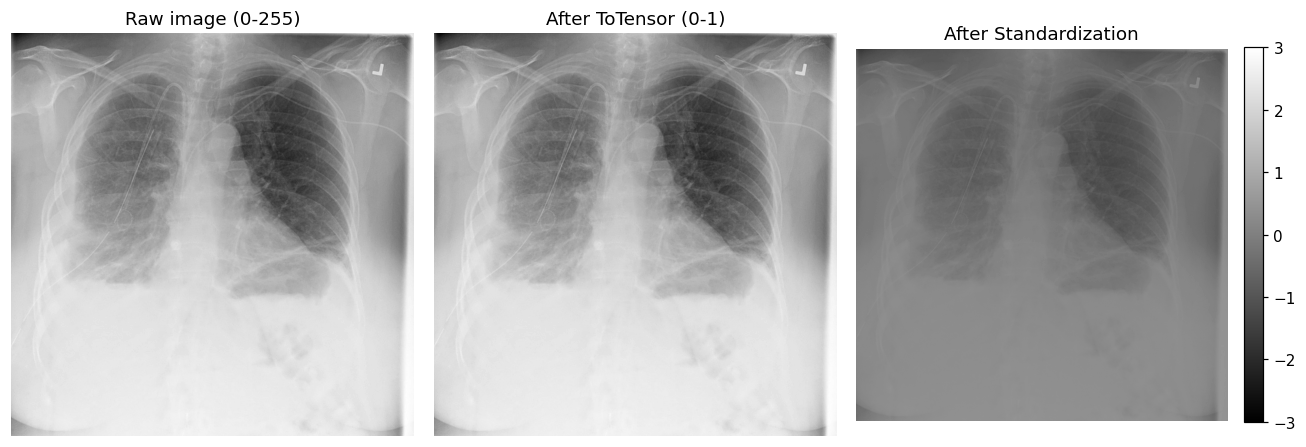

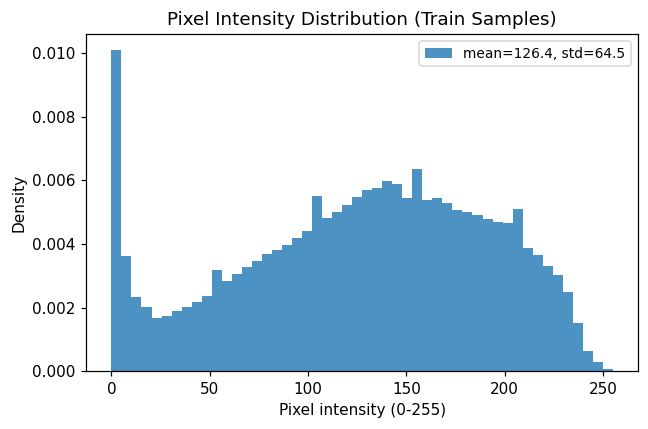

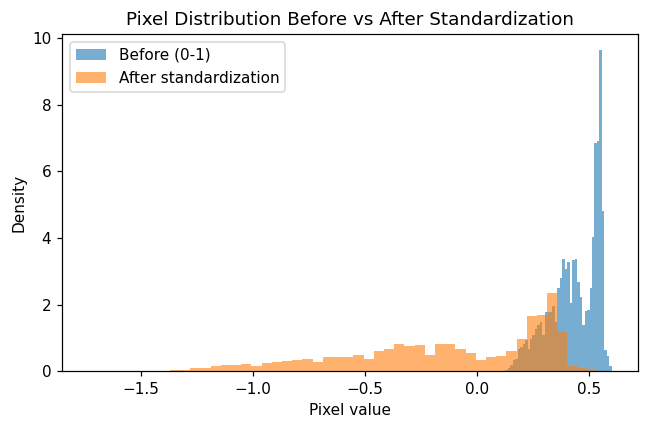

In [9]:
# ====== EDA: pixel intensity distribution on training images ======
import random
from PIL import Image

# 最多抽 100 张图
all_paths = train_df["full_path"].tolist()
sample_paths = random.sample(all_paths, k=min(100, len(all_paths)))

pixels = []

for fp in sample_paths:
    img = Image.open(fp).convert("L")  # 灰度
    arr = np.array(img, dtype=np.float32)
    pixels.extend(arr.ravel())

pixels = np.array(pixels)
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from PIL import Image
import torch

def show_norm_before_after(idx: int = 0):
    row = train_df.iloc[idx]
    img_path = row["full_path"] 
    img = Image.open(img_path).convert("L")

    img_01 = TF.to_tensor(img) 

    mean = torch.tensor([IMG_MEAN]).view(-1, 1, 1)
    std  = torch.tensor([IMG_STD]).view(-1, 1, 1)
    img_std = (img_01 - mean) / std

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(img, cmap="gray")
    axs[0].set_title("Raw image (0-255)")
    axs[0].axis("off")

    axs[1].imshow(img_01.squeeze().numpy(), cmap="gray")
    axs[1].set_title("After ToTensor (0-1)")
    axs[1].axis("off")

    im2 = axs[2].imshow(
        img_std.squeeze().numpy(),
        cmap="gray",
        vmin=-3, vmax=3   
    )
    axs[2].set_title("After Standardization")
    axs[2].axis("off")
    fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

show_norm_before_after(idx=0)

mean_pix = pixels.mean()
std_pix  = pixels.std()

plt.figure(figsize=(6, 4))
plt.hist(pixels, bins=50, density=True, alpha=0.8)

plt.xlabel("Pixel intensity (0-255)")
plt.ylabel("Density")
plt.title("Pixel Intensity Distribution (Train Samples)")

# legend 带 mean/std
plt.legend(
    [f"mean={mean_pix:.1f}, std={std_pix:.1f}"],
    loc="upper right",
    fontsize=9
)

plt.tight_layout()
plt.show()
plt.savefig(os.path.join(EDA_DIR, "pixel_intensity_hist_train.png"), dpi=300)
plt.close()


def plot_intensity_hist_before_after(idx: int = 0):
    row = train_df.iloc[idx]
    img_path = row["full_path"]
    img = Image.open(img_path).convert("L")

    img_01 = TF.to_tensor(img)      
    mean = torch.tensor([IMG_MEAN]).view(-1, 1, 1)
    std  = torch.tensor([IMG_STD]).view(-1, 1, 1)
    img_std = (img_01 - mean) / std  

    plt.figure(figsize=(6, 4))
    plt.hist(
        img_01.flatten().numpy(),
        bins=50, density=True, alpha=0.6,
        label="Before (0-1)"
    )
    plt.hist(
        img_std.flatten().numpy(),
        bins=50, density=True, alpha=0.6,
        label="After standardization"
    )
    plt.xlabel("Pixel value")
    plt.ylabel("Density")
    plt.title("Pixel Distribution Before vs After Standardization")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_intensity_hist_before_after(idx=0)

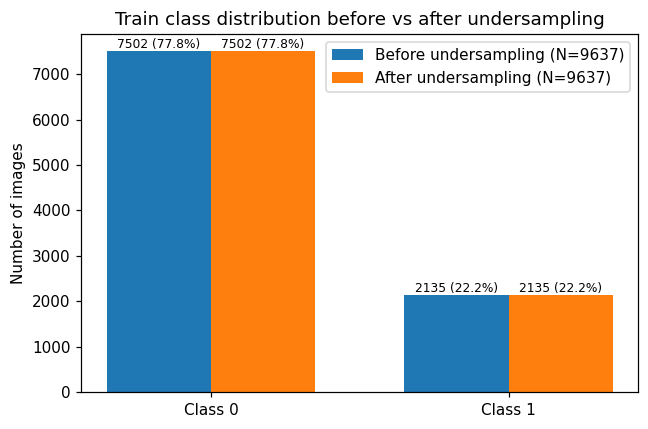

[Info] Saved: ./ConvNeXt+UNet(8,1,1)_base7_Output\class_dist_before_after_undersampling.png


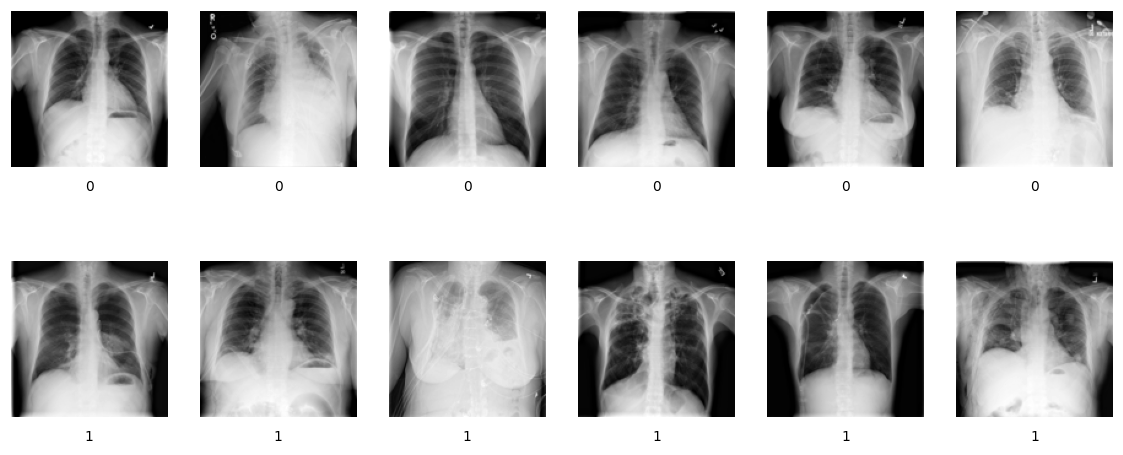

In [10]:
import matplotlib.pyplot as plt
import numpy as np

before_counts = train_tmp["has_pneumo"].value_counts().sort_index()
after_counts  = tr_df["has_pneumo"].value_counts().sort_index()

classes = before_counts.index.tolist() 
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(6, 4))

bars_before = plt.bar(x - width/2, before_counts.values,
                      width, label=f"Before undersampling (N={len(train_tmp)})")
bars_after  = plt.bar(x + width/2, after_counts.values,
                      width, label=f"After undersampling (N={len(tr_df)})")

total_before = before_counts.sum()
total_after  = after_counts.sum()

for bar, count in zip(bars_before, before_counts.values):
    pct = 100.0 * count / total_before
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height(),
             f"{count} ({pct:.1f}%)",
             ha="center", va="bottom", fontsize=8)

for bar, count in zip(bars_after, after_counts.values):
    pct = 100.0 * count / total_after
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height(),
             f"{count} ({pct:.1f}%)",
             ha="center", va="bottom", fontsize=8)

plt.xticks(x, [f"Class {c}" for c in classes])
plt.ylabel("Number of images")
plt.title("Train class distribution before vs after undersampling")
plt.legend()
plt.tight_layout()

save_path = os.path.join(OUT_DIR, "class_dist_before_after_undersampling.png")
plt.savefig(save_path, dpi=300)
plt.show()

print(f"[Info] Saved: {save_path}")


eda_sample_grid(train_df, os.path.join(EDA_DIR, "sample_grid_train.png"), "Train", n_per_class=6, size=128)

In [11]:


# Transforms
# Transforms
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),                          # [0,1]
    transforms.Normalize(mean=[IMG_MEAN], std=[IMG_STD]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),                          # [0,1]
    transforms.Normalize(mean=[IMG_MEAN], std=[IMG_STD]),
])


# Joint transforms for image + mask (training set)
joint_train_tfms = JointImageMaskTransform(out_size=IMG_SIZE)

# Datasets
ds_train = PandasImageMaskDataset(tr_df, mask_root=MASK_ROOT, joint_transform=joint_train_tfms)
ds_val   = PandasImageDataset(val_df, transform=eval_tfms)
ds_test  = PandasImageDataset(test_df, transform=eval_tfms)

def make_weights_for_balancing(df: pd.DataFrame) -> np.ndarray:
    counts = df["has_pneumo"].value_counts().to_dict()
    return df["has_pneumo"].map(lambda y: 1.0 / counts[int(y)]).values.astype(np.float32)


if SAMPLER == "on":
    weights = make_weights_for_balancing(tr_df)
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    shuffle = False
else:
    sampler = None; shuffle = True

train_labels = tr_df["has_pneumo"].values

balanced_sampler = BalancedBatchSampler(
    labels=train_labels,
    batch_size=BATCH,
    pos_label=1,
    neg_label=0,
    drop_last=True,
)

# DataLoaders
dl_train = DataLoader(
    ds_train,
    batch_sampler=balanced_sampler,
    num_workers=0,
    pin_memory=True,
)
dl_val   = DataLoader(ds_val, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
dl_test  = DataLoader(ds_test, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

# Use eval dataset for train_eval
ds_train_eval = PandasImageDataset(tr_df, transform=eval_tfms)
dl_train_eval = DataLoader(
    ds_train_eval, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True
)


len(ds_train), len(ds_val), len(ds_test)

(9637, 1205, 1205)

In [12]:
import os
import numpy as np
from PIL import Image

first_pos_idx = 1  

row = tr_df.iloc[first_pos_idx]
img_path = row["full_path"]
basename = os.path.basename(img_path)

print("img_path:", img_path)
print("basename:", basename)

print("MASK_ROOT:", MASK_ROOT)
mask_path = os.path.join(MASK_ROOT, basename)
print("mask_path:", mask_path, "exists:", os.path.exists(mask_path))

mask_raw = Image.open(mask_path).convert("L")
mask_np = np.array(mask_raw)

print("raw mask shape:", mask_np.shape)
print("raw mask min/max:", mask_np.min(), mask_np.max())
print("raw mask positive pixels (>0):", (mask_np > 0).sum())


img_path: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images\1507_train_1_.png
basename: 1507_train_1_.png
MASK_ROOT: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_masks
mask_path: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_masks\1507_train_1_.png exists: True
raw mask shape: (1024, 1024)
raw mask min/max: 0 255
raw mask positive pixels (>0): 14635


In [13]:
pos_indices = [i for i, v in enumerate(tr_df["has_pneumo"].values) if v == 1]
print("Positive sample number:", len(pos_indices))
first_pos_idx = pos_indices[0]

img, y, mask = ds_train[first_pos_idx]
print("index:", first_pos_idx)
print("label:", y)
print("mask shape:", mask.shape)
print("mask min/max:", mask.min().item(), mask.max().item())
print("mask positive pixels:", mask.sum().item())

Positive sample number: 2135
index: 1
label: 1.0
mask shape: torch.Size([1, 576, 576])
mask min/max: 0.0 1.0
mask positive pixels: 5329.0


# ConvNeXt_V2
## DropPath (Random Depth)

In [14]:
def drop_path(x, drop_prob: float = 0.0, training: bool = False):
    if drop_prob == 0.0 or not training:
        return x
    keep_prob = 1.0 - drop_prob
    # Only sample along batch dimension, broadcast others
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    return x * random_tensor / keep_prob

class DropPath(nn.Module):
    def __init__(self, drop_prob: float = 0.0):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

## GRN

In [15]:
class GRN(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1, 1, 1, dim))
        self.beta = nn.Parameter(torch.zeros(1, 1, 1, dim))

    def forward(self, x):
        gx = torch.norm(x, p=2, dim=(1, 2), keepdim=True)                # [N,1,1,C]
        nx = gx / (gx.mean(dim=-1, keepdim=True) + 1e-6)                 # [N,1,1,C]
        return self.gamma * (x * nx) + self.beta + x                     # [N,H,W,C]

## LayerNorm2d

In [16]:
class LayerNorm2d(nn.Module):
    def __init__(self, num_channels: int, eps: float = 1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        var = (x - mean).pow(2).mean(dim=1, keepdim=True)
        x = (x - mean) / torch.sqrt(var + self.eps)
        return self.weight.view(1, -1, 1, 1) * x + self.bias.view(1, -1, 1, 1)

## ConvNeXt_V2 block

In [17]:
class ConvNeXtV2Block(nn.Module):
    def __init__(
        self,
        dim: int,
        mlp_ratio: float = 4.0,
        drop_path: float = 0.0,
        layer_scale_init_value: float = 0.0,  
    ):
        super().__init__()
        # 7x7 depthwise convolution
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)

        # Do LayerNorm in channels_last format
        self.norm = nn.LayerNorm(dim, eps=1e-6)

        hidden_dim = int(dim * mlp_ratio)
        self.pwconv1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.grn = GRN(hidden_dim)
        self.pwconv2 = nn.Linear(hidden_dim, dim)

        # LayerScale
        if layer_scale_init_value > 0:
            self.gamma = nn.Parameter(layer_scale_init_value * torch.ones(dim))
        else:
            self.gamma = None

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

    def forward(self, x):
        shortcut = x  # [N, C, H, W]

        x = self.dwconv(x)

        # NCHW -> NHWC
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.grn(x)
        x = self.pwconv2(x)

        if self.gamma is not None:
            x = self.gamma.view(1, 1, 1, -1) * x

        # NHWC -> NCHW
        x = x.permute(0, 3, 1, 2)

        x = shortcut + self.drop_path(x)
        return x

## U-Net Decoder Block

In [18]:
class DecoderBlock(nn.Module):
    def __init__(self, in_ch: int, skip_ch: int, out_ch: int):
        super().__init__()
        self.has_skip = skip_ch > 0

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

        self.conv1 = nn.Conv2d(in_ch + (skip_ch if skip_ch > 0 else 0),
                               out_ch, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_ch)

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.act   = nn.ReLU(inplace=True)

    def forward(self, x, skip=None):
        # Oversample
        x = self.upsample(x)

        if self.has_skip and skip is not None:
            if skip.shape[-2:] != x.shape[-2:]:
                skip = F.interpolate(skip, size=x.shape[-2:], mode="bilinear", align_corners=False)
            x = torch.cat([x, skip], dim=1)

        x = self.act(self.bn1(self.conv1(x)))
        x = self.act(self.bn2(self.conv2(x)))
        return x


## ConvNeXt_V2 tiny

In [19]:
class ConvNeXtV2Tiny(nn.Module):
    def __init__(
        self,
        in_chans: int = 3,
        num_classes: int = 1000,
        drop_path_rate: float = 0.0,
        layer_scale_init_value: float = 0.0, 
    ):
        super().__init__()

        # 4 deepths and dims for each stage
        depths = [3, 3, 9, 3]
        dims = [96, 192, 384, 768]

        self.downsample_layers = nn.ModuleList()
        self.stages = nn.ModuleList()

        # Constructing the stem: patch embedding with stride=4
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm2d(dims[0]),
        )
        self.downsample_layers.append(stem)

        # Constructing the blocks and downsampling layers for each stage
        total_blocks = sum(depths)
        dpr_values = torch.linspace(0, drop_path_rate, total_blocks).tolist()
        block_idx = 0

        for stage_idx in range(4):
            depth = depths[stage_idx]
            dim = dims[stage_idx]

            # Every stage begins with a downsampling layer (except the first)
            if stage_idx > 0:
                down = nn.Sequential(
                    LayerNorm2d(dims[stage_idx - 1]),
                    nn.Conv2d(dims[stage_idx - 1], dim, kernel_size=2, stride=2),
                )
                self.downsample_layers.append(down)

            blocks = []
            for i in range(depth):
                blocks.append(
                    ConvNeXtV2Block(
                        dim=dim,
                        mlp_ratio=4.0,
                        drop_path=dpr_values[block_idx + i],
                        layer_scale_init_value=layer_scale_init_value,
                    )
                )
            block_idx += depth

            self.stages.append(nn.Sequential(*blocks))

        # The last classification head: LN + Linear
        self.norm_head = nn.LayerNorm(dims[-1], eps=1e-6)
        self.head = (
            nn.Linear(dims[-1], num_classes) if num_classes > 0 else nn.Identity()
        )

    def forward_features(self, x):
        # Downsampling through stages
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)

        # Global average pooling and normalization
        x = x.mean(dim=[2, 3])
        x = self.norm_head(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)  # [N, num_classes]
        return x
    
class ConvNeXtV2TinyScratch(nn.Module):
    """
    ConvNeXtV2Tiny as encoder
    + U-Net decoder with skip connections
    + cls head (global pooling) + seg head
    """
    def __init__(
        self,
        in_chans: int = 1,
        n_classes: int = 1,
        drop_path_rate: float = 0.1,
    ):
        super().__init__()

        self.backbone = ConvNeXtV2Tiny(
            in_chans=in_chans,
            num_classes=n_classes,
            drop_path_rate=drop_path_rate,
            layer_scale_init_value=0.0,
        )

        # Channel dims at each stage of ConvNeXtV2Tiny
        dims = [96, 192, 384, 768]
        last_dim = dims[-1]   # The deepest 768

        # ===== Classification head =====
        self.cls_head = nn.Linear(last_dim, n_classes)

        # ===== U-Net decoder =====
        # encoder output: x1(1/4, 96), x2(1/8, 192), x3(1/16,384), x4(1/32,768)
        self.dec3 = DecoderBlock(in_ch=dims[3], skip_ch=dims[2], out_ch=dims[2])   # 1/32 -> 1/16
        self.dec2 = DecoderBlock(in_ch=dims[2], skip_ch=dims[1], out_ch=dims[1])   # 1/16 -> 1/8
        self.dec1 = DecoderBlock(in_ch=dims[1], skip_ch=dims[0], out_ch=dims[0])   # 1/8  -> 1/4
        self.dec0 = DecoderBlock(in_ch=dims[0], skip_ch=0,        out_ch=max(dims[0] // 2, 32))  # 1/4 -> 1/2

        # Segmentation head：convalution to 1 channel
        self.seg_head = nn.Conv2d(max(dims[0] // 2, 32), 1, kernel_size=1)

    def forward_backbone_pyramid(self, x):
        """
        Return feature pyramid from backbone
        x1: 1/4,  x2: 1/8,  x3: 1/16, x4: 1/32
        """
        feats = []
        for i in range(4):
            x = self.backbone.downsample_layers[i](x)
            x = self.backbone.stages[i](x)
            feats.append(x)
        return feats  # [x1, x2, x3, x4]

    def forward(self, x):
        # ---- Encoder ----
        x1, x2, x3, x4 = self.forward_backbone_pyramid(x)

        # ---- Classification branch----
        gap = x4.mean(dim=[2, 3])          # [B, C4]
        gap = self.backbone.norm_head(gap) 
        cls_logits = self.cls_head(gap)    # [B, 1]
        cls_logits = cls_logits.squeeze(1) # [B]

        # ---- U-Net Decoder + Segmentation head ----
        d3 = self.dec3(x4, x3)    # 1/32 -> 1/16
        d2 = self.dec2(d3, x2)    # 1/16 -> 1/8
        d1 = self.dec1(d2, x1)    # 1/8  -> 1/4
        d0 = self.dec0(d1, None)  # 1/4  -> 1/2

        seg_logits = self.seg_head(d0)  # [B,1,H_dec,W_dec]

        seg_logits = F.interpolate(
            seg_logits,
            size=x.shape[-2:],
            mode="bilinear",
            align_corners=False,
        )

        return cls_logits, seg_logits

model = ConvNeXtV2TinyScratch(in_chans=1, n_classes=1, drop_path_rate=0.1).to(device)

## Parameter counts

In [20]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total params:      {total:,}")
    print(f"Trainable params:  {trainable:,}")
    print(f"Total params (M):  {total / 1e6:.2f} M")
    print(f"Trainable (M):     {trainable / 1e6:.2f} M")

count_parameters(model)


Total params:      34,898,835
Trainable params:  34,898,835
Total params (M):  34.90 M
Trainable (M):     34.90 M


## Loss：Tversky + Focal

### Tversky Loss

In [21]:
# Weights initialization
LAMBDA_SEG = 0.3

class TverskyLoss(nn.Module):
    def __init__(self, alpha: float = 0.3, beta: float = 0.7,
                 smooth: float = 1e-6, pos_only: bool = True):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth
        self.pos_only = pos_only

    def forward(self, logits, targets):
        """
        logits: [B,1,H,W]
        targets: [B,1,H,W] (0/1)
        """
        probs = torch.sigmoid(logits)
        targets = targets.float()

        B = probs.size(0)
        probs_flat   = probs.view(B, -1)
        targets_flat = targets.view(B, -1)

        # Only calculate positive sample using Tversky
        if self.pos_only:
            pos_mask = (targets_flat.sum(dim=1) > 0)
            if pos_mask.any():
                probs_flat   = probs_flat[pos_mask]
                targets_flat = targets_flat[pos_mask]
            else:
                return logits.new_tensor(0.0)

        TP = (probs_flat * targets_flat).sum(dim=1)
        FP = (probs_flat * (1.0 - targets_flat)).sum(dim=1)
        FN = ((1.0 - probs_flat) * targets_flat).sum(dim=1)

        tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        loss = 1.0 - tversky
        return loss.mean()

### Focal Loss

In [22]:
# Calculate class weights for Focal Loss
pos = (np.array(tr_df["has_pneumo"]) == 1).sum()
neg = (np.array(tr_df["has_pneumo"]) == 0).sum()

# alpha = neg / (pos + neg + 1e-8) 
alpha = 0.5 

print(f"Train pos={pos}, neg={neg}, alpha={alpha:.4f}")

# Define Binary Focal Loss
class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        if logits.dim() > targets.dim():
            targets = targets.view_as(logits)
        targets = targets.float()

        # Probabilities for the true class
        prob = torch.sigmoid(logits)
        pt = prob * targets + (1 - prob) * (1 - targets)  

        # Weighted alpha factor
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)

        # Focal weight
        focal_weight = alpha_t * (1 - pt).pow(self.gamma)

        # Basic BCE with logits
        bce = F.binary_cross_entropy_with_logits(
            logits, targets, reduction="none"
        )
        loss = focal_weight * bce

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

# Create criterion, optimizer, scheduler, scaler
criterion_cls  = BinaryFocalLoss(alpha=alpha, gamma=2.0)   # clf
criterion_segF = BinaryFocalLoss(alpha=0.5,   gamma=2.0)   # seg
criterion_segT = TverskyLoss(alpha=0.3, beta=0.7, pos_only=True)

# Optimizer / Scheduler / AMP
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


Train pos=2135, neg=7502, alpha=0.5000


C:\Users\Steven\AppData\Local\Temp\ipykernel_24616\2008830913.py:53: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


In [23]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve
)

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    ys, preds, scores = [], [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        out = model(xb)
        if isinstance(out, tuple):
            logits, _ = out          # (cls_logits, seg_logits) → cls_logits
        else:
            logits = out

        probs = torch.sigmoid(logits)  # [B]
        pred = (probs >= 0.5).long()

        ys.extend(yb.cpu().numpy().tolist())
        preds.extend(pred.cpu().numpy().tolist())
        scores.extend(probs.cpu().numpy().tolist())

    y_true = np.array(ys)
    y_pred = np.array(preds)
    y_score = np.array(scores)

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    # Specificity = TN / (TN + FP)
    try:
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp + 1e-8)
        else:
            spec = float("nan")
    except Exception:
        spec = float("nan")

    # ROC-AUC & PR-AUC
    try:
        roc = roc_auc_score(y_true, y_score)
    except Exception:
        roc = float("nan")

    try:
        pr  = average_precision_score(y_true, y_score)
    except Exception:
        pr  = float("nan")

    metrics = {
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "spec": spec,
        "roc_auc": roc,
        "pr_auc": pr,
    }
    return metrics, y_true, y_pred, y_score

def plot_confusion_matrix(y_true, y_pred, out_path, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ['0','1']); plt.yticks(ticks, ['0','1'])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
    plt.ylabel("Actual"); plt.xlabel("Predicted")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.show()

def plot_roc_pr(y_true, y_score, out_dir, prefix="eval",
                roc_auc=None, pr_auc=None):
    os.makedirs(out_dir, exist_ok=True)

    # ROC
    try:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})" if roc_auc is not None else "ROC")
        plt.plot([0,1],[0,1], linestyle="--", label="Random")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve ({prefix})")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{prefix}_roc.png"), dpi=300)
        plt.show()
    except Exception as e:
        print("ROC failed:", e)

    # PR
    try:
        prec, rec, _ = precision_recall_curve(y_true, y_score)
        plt.figure(figsize=(5,4))
        plt.plot(rec, prec, label=f"PR (AP={pr_auc:.3f})" if pr_auc is not None else "PR")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision–Recall Curve ({prefix})")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{prefix}_pr.png"), dpi=300)
        plt.show()
    except Exception as e:
        print("PR failed:", e)

def plot_learning_curves(history, best_epoch, out_dir, prefix="convnextv2_tiny"):
    os.makedirs(out_dir, exist_ok=True)

    epochs = np.arange(1, best_epoch + 1)

    train_loss = history["train_loss"][:best_epoch]
    val_loss   = history["val_loss"][:best_epoch]
    val_f1     = np.array(history["val_f1"][:best_epoch]) * 100.0

    # --- Loss Learning Curve ---
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss,   label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Learning Curve (Loss, Best Epoch = {best_epoch})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_learning_loss_best.png"), dpi=300)
    plt.show()

    # --- F1 Learning Curve ---
    plt.figure(figsize=(6,4))
    plt.plot(epochs, val_f1, marker="o", label="Val F1 (macro)")
    plt.xlabel("Epoch")
    plt.ylabel("Val F1 (%)")
    plt.title(f"Learning Curve (Val F1, Best Epoch = {best_epoch})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_learning_f1_best.png"), dpi=300)
    plt.show()

def plot_accuracy_curve(history, best_epoch, out_dir, prefix="convnextv2_tiny"):
    os.makedirs(out_dir, exist_ok=True)

    epochs  = np.arange(1, best_epoch + 1)
    val_acc = np.array(history["val_acc"][:best_epoch]) * 100.0

    plt.figure(figsize=(6,4))
    plt.plot(epochs, val_acc, marker="o", label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Val Accuracy (%)")
    plt.title(f"Learning Curve (Val Accuracy, Best Epoch = {best_epoch})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_learning_acc_best.png"), dpi=300)
    plt.show()

In [24]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

backbone.downsample_layers.0.0.weight
backbone.downsample_layers.0.0.bias
backbone.downsample_layers.0.1.weight
backbone.downsample_layers.0.1.bias
backbone.downsample_layers.1.0.weight
backbone.downsample_layers.1.0.bias
backbone.downsample_layers.1.1.weight
backbone.downsample_layers.1.1.bias
backbone.downsample_layers.2.0.weight
backbone.downsample_layers.2.0.bias
backbone.downsample_layers.2.1.weight
backbone.downsample_layers.2.1.bias
backbone.downsample_layers.3.0.weight
backbone.downsample_layers.3.0.bias
backbone.downsample_layers.3.1.weight
backbone.downsample_layers.3.1.bias
backbone.stages.0.0.dwconv.weight
backbone.stages.0.0.dwconv.bias
backbone.stages.0.0.norm.weight
backbone.stages.0.0.norm.bias
backbone.stages.0.0.pwconv1.weight
backbone.stages.0.0.pwconv1.bias
backbone.stages.0.0.grn.gamma
backbone.stages.0.0.grn.beta
backbone.stages.0.0.pwconv2.weight
backbone.stages.0.0.pwconv2.bias
backbone.stages.0.1.dwconv.weight
backbone.stages.0.1.dwconv.bias
backbone.stages.0.1

In [25]:
from tqdm.auto import tqdm

# Early Stopping parameters
MONITOR    = "pr_auc" 
MODE       = "max"
PATIENCE   = 8
MIN_EPOCHS = 10
DELTA      = 1e-4

best_score   = -float('inf')
best_epoch   = 0
epochs_bad   = 0
BEST_STATE   = None

history = {
    "train_acc":  [],
    "train_loss": [],
    "val_loss":   [],
    "val_acc":    [],
    "val_prec":   [],
    "val_rec":    [],
    "val_f1":     [],
    "val_spec":   [],
    "val_roc":    [],
    "val_pr":     [],
}

print("[Info] Start training...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    running, running_cls, running_seg, nb = 0.0, 0.0, 0.0, 0 
    
    train_correct = 0
    train_total   = 0

    bar = tqdm(total=len(dl_train), leave=True, desc=f"Epoch {epoch}/{EPOCHS}")

    for xb, yb, mb in dl_train:   # clf + seg
        xb = xb.to(device, non_blocking=True)         # [B, 1, H, W]
        yb = yb.to(device, non_blocking=True).float() # [B]
        mb = mb.to(device, non_blocking=True).float() # [B, 1, H, W]

        optimizer.zero_grad(set_to_none=True)

        # Mixed precision
        with torch.amp.autocast('cuda', enabled=(device.type == 'cuda')):
            cls_logits, seg_logits = model(xb)   # cls_logits: [B] or [B,1], seg_logits: [B,1,H,W]

            # Classification branch：Focal Loss
            cls_loss = criterion_cls(cls_logits, yb)

            # Segmentation branch：Focal Loss + Tversky Loss
            seg_loss_focal   = criterion_segF(seg_logits, mb)
            seg_loss_tversky = criterion_segT(seg_logits, mb)
            seg_loss = seg_loss_focal + seg_loss_tversky

            # Total loss
            loss = cls_loss + LAMBDA_SEG * seg_loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Sum of three losses
        running      += loss.item()
        running_cls  += cls_loss.item()
        running_seg  += seg_loss.item()
        nb           += 1

        # 👉 这里顺便统计训练集 accuracy
        with torch.no_grad():
            # 保证 logits 展平为 [B]
            if cls_logits.ndim > 1:
                cls_logits_batch = cls_logits.view(-1)
            else:
                cls_logits_batch = cls_logits

            probs = torch.sigmoid(cls_logits_batch)
            preds = (probs >= 0.5).float()     # 阈值 0.5
            train_correct += (preds == yb).sum().item()
            train_total   += yb.size(0)

        try:
            curr_lr = scheduler.get_last_lr()[0]
        except Exception:
            curr_lr = optimizer.param_groups[0]["lr"]

        bar.set_postfix(
            loss=f"{running / max(nb, 1):.4f}",
            cls=f"{running_cls / max(nb, 1):.4f}",
            seg=f"{running_seg / max(nb, 1):.8f}",
            lr=f"{curr_lr:.2e}",
        )
        bar.update(1)

    scheduler.step()
    bar.close()

    train_loss_epoch = running / max(nb, 1)
    train_acc_epoch  = train_correct / max(train_total, 1)

    model.eval()
    val_running, val_nb = 0.0, 0
    with torch.no_grad():
        for xb, yb in dl_val:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True).float()

            with torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
                out = model(xb)
                if isinstance(out, tuple):
                    logits, _ = out
                else:
                    logits = out
                loss_val = criterion_cls(logits, yb)

            val_running += loss_val.item()
            val_nb += 1
    val_loss_epoch = val_running / max(val_nb, 1)

    metrics, yv, pv, sv = evaluate(model, dl_val, device)
    score = float(metrics.get(MONITOR, float('nan')))
    improved = score > (best_score + DELTA)

    history["train_acc"].append(train_acc_epoch)
    history["train_loss"].append(train_loss_epoch)
    history["val_loss"].append(val_loss_epoch)
    history["val_acc"].append(metrics["acc"])
    history["val_prec"].append(metrics["prec"])
    history["val_rec"].append(metrics["rec"])
    history["val_f1"].append(metrics["f1"])
    history["val_spec"].append(metrics["spec"])
    history["val_roc"].append(metrics["roc_auc"])
    history["val_pr"].append(metrics["pr_auc"])

    if improved:
        best_score = score
        best_epoch = epoch
        BEST_STATE = {k: v.cpu() for k, v in model.state_dict().items()}
        epochs_bad = 0
    else:
        epochs_bad += 1

    tqdm.write(
        f"Epoch {epoch:02d}/{EPOCHS} "
        f"train_loss={train_loss_epoch:.4f} val_loss={val_loss_epoch:.4f} "
        f"train_acc={train_acc_epoch:.4f} "
        f"val_acc={metrics['acc']:.4f} val_prec={metrics['prec']:.4f} "
        f"val_rec={metrics['rec']:.4f} val_f1={metrics['f1']:.4f} "
        f"val_spec={metrics['spec']:.4f} "
        f"val_roc={metrics['roc_auc']:.4f} val_pr={metrics['pr_auc']:.4f} "
        f"| val_{MONITOR}={score:.4f} best_{MONITOR}={best_score:.4f} (epoch {best_epoch})"
    )

    if epoch >= MIN_EPOCHS and epochs_bad >= PATIENCE:
        tqdm.write(f"[EarlyStop] Stop at epoch {epoch}. Best {MONITOR}={best_score:.4f} @ epoch {best_epoch}.")
        break

# Save best model
if BEST_STATE is not None:
    torch.save(BEST_STATE, os.path.join(OUT_DIR, "best_cnn.pt"))
    model.load_state_dict(BEST_STATE)


[Info] Start training...


Epoch 1/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 01/120 train_loss=0.3728 val_loss=0.0809 train_acc=0.5276 val_acc=0.6938 val_prec=0.3097 val_rec=0.3109 val_f1=0.3103 val_spec=0.8028 val_roc=0.6400 val_pr=0.2991 | val_pr_auc=0.2991 best_pr_auc=0.2991 (epoch 1)


Epoch 2/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 02/120 train_loss=0.3159 val_loss=0.0900 train_acc=0.5370 val_acc=0.4622 val_prec=0.2729 val_rec=0.8577 val_f1=0.4141 val_spec=0.3497 val_roc=0.6486 val_pr=0.2973 | val_pr_auc=0.2973 best_pr_auc=0.2991 (epoch 1)


Epoch 3/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 03/120 train_loss=0.3034 val_loss=0.0818 train_acc=0.5879 val_acc=0.6307 val_prec=0.3460 val_rec=0.7491 val_f1=0.4734 val_spec=0.5970 val_roc=0.7301 val_pr=0.3949 | val_pr_auc=0.3949 best_pr_auc=0.3949 (epoch 3)


Epoch 4/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 04/120 train_loss=0.2923 val_loss=0.0689 train_acc=0.6338 val_acc=0.7245 val_prec=0.4286 val_rec=0.7303 val_f1=0.5402 val_spec=0.7228 val_roc=0.8065 val_pr=0.5310 | val_pr_auc=0.5310 best_pr_auc=0.5310 (epoch 4)


Epoch 5/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 05/120 train_loss=0.2807 val_loss=0.0665 train_acc=0.6846 val_acc=0.7751 val_prec=0.4950 val_rec=0.7378 val_f1=0.5925 val_spec=0.7857 val_roc=0.8295 val_pr=0.5677 | val_pr_auc=0.5677 best_pr_auc=0.5677 (epoch 5)


Epoch 6/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 06/120 train_loss=0.2749 val_loss=0.0699 train_acc=0.6999 val_acc=0.7527 val_prec=0.4665 val_rec=0.8090 val_f1=0.5918 val_spec=0.7367 val_roc=0.8308 val_pr=0.5847 | val_pr_auc=0.5847 best_pr_auc=0.5847 (epoch 6)


Epoch 7/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 07/120 train_loss=0.2665 val_loss=0.0862 train_acc=0.7144 val_acc=0.6141 val_prec=0.3536 val_rec=0.8951 val_f1=0.5069 val_spec=0.5341 val_roc=0.8129 val_pr=0.5465 | val_pr_auc=0.5465 best_pr_auc=0.5847 (epoch 6)


Epoch 8/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 08/120 train_loss=0.2632 val_loss=0.0733 train_acc=0.7296 val_acc=0.7145 val_prec=0.4286 val_rec=0.8652 val_f1=0.5732 val_spec=0.6716 val_roc=0.8326 val_pr=0.5927 | val_pr_auc=0.5927 best_pr_auc=0.5927 (epoch 8)


Epoch 9/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 09/120 train_loss=0.2619 val_loss=0.0656 train_acc=0.7245 val_acc=0.7444 val_prec=0.4524 val_rec=0.7303 val_f1=0.5587 val_spec=0.7484 val_roc=0.8108 val_pr=0.5446 | val_pr_auc=0.5446 best_pr_auc=0.5927 (epoch 8)


Epoch 10/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 10/120 train_loss=0.2541 val_loss=0.0502 train_acc=0.7474 val_acc=0.8108 val_prec=0.5759 val_rec=0.5543 val_f1=0.5649 val_spec=0.8838 val_roc=0.8518 val_pr=0.6272 | val_pr_auc=0.6272 best_pr_auc=0.6272 (epoch 10)


Epoch 11/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 11/120 train_loss=0.2514 val_loss=0.0533 train_acc=0.7619 val_acc=0.8033 val_prec=0.5399 val_rec=0.7603 val_f1=0.6314 val_spec=0.8156 val_roc=0.8706 val_pr=0.6664 | val_pr_auc=0.6664 best_pr_auc=0.6664 (epoch 11)


Epoch 12/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 12/120 train_loss=0.2500 val_loss=0.0628 train_acc=0.7535 val_acc=0.7701 val_prec=0.4892 val_rec=0.8502 val_f1=0.6211 val_spec=0.7473 val_roc=0.8681 val_pr=0.6231 | val_pr_auc=0.6231 best_pr_auc=0.6664 (epoch 11)


Epoch 13/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 13/120 train_loss=0.2480 val_loss=0.0621 train_acc=0.7680 val_acc=0.7751 val_prec=0.4954 val_rec=0.8090 val_f1=0.6145 val_spec=0.7655 val_roc=0.8534 val_pr=0.6237 | val_pr_auc=0.6237 best_pr_auc=0.6664 (epoch 11)


Epoch 14/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 14/120 train_loss=0.2439 val_loss=0.0560 train_acc=0.7680 val_acc=0.8075 val_prec=0.5457 val_rec=0.7828 val_f1=0.6431 val_spec=0.8145 val_roc=0.8727 val_pr=0.6598 | val_pr_auc=0.6598 best_pr_auc=0.6664 (epoch 11)


Epoch 15/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 15/120 train_loss=0.2399 val_loss=0.0588 train_acc=0.7842 val_acc=0.7718 val_prec=0.4908 val_rec=0.7978 val_f1=0.6077 val_spec=0.7644 val_roc=0.8651 val_pr=0.6561 | val_pr_auc=0.6561 best_pr_auc=0.6664 (epoch 11)


Epoch 16/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 16/120 train_loss=0.2406 val_loss=0.0542 train_acc=0.7741 val_acc=0.8174 val_prec=0.5586 val_rec=0.8390 val_f1=0.6707 val_spec=0.8113 val_roc=0.8883 val_pr=0.6925 | val_pr_auc=0.6925 best_pr_auc=0.6925 (epoch 16)


Epoch 17/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 17/120 train_loss=0.2348 val_loss=0.0564 train_acc=0.7926 val_acc=0.8066 val_prec=0.5401 val_rec=0.8577 val_f1=0.6628 val_spec=0.7921 val_roc=0.8821 val_pr=0.6919 | val_pr_auc=0.6919 best_pr_auc=0.6925 (epoch 16)


Epoch 18/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 18/120 train_loss=0.2332 val_loss=0.0705 train_acc=0.7978 val_acc=0.7286 val_prec=0.4436 val_rec=0.8839 val_f1=0.5907 val_spec=0.6844 val_roc=0.8683 val_pr=0.6445 | val_pr_auc=0.6445 best_pr_auc=0.6925 (epoch 16)


Epoch 19/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 19/120 train_loss=0.2303 val_loss=0.0592 train_acc=0.7917 val_acc=0.7884 val_prec=0.5130 val_rec=0.8876 val_f1=0.6502 val_spec=0.7601 val_roc=0.8967 val_pr=0.7124 | val_pr_auc=0.7124 best_pr_auc=0.7124 (epoch 19)


Epoch 20/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 20/120 train_loss=0.2286 val_loss=0.0671 train_acc=0.7980 val_acc=0.7220 val_prec=0.4349 val_rec=0.8502 val_f1=0.5754 val_spec=0.6855 val_roc=0.8617 val_pr=0.6460 | val_pr_auc=0.6460 best_pr_auc=0.7124 (epoch 19)


Epoch 21/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 21/120 train_loss=0.2249 val_loss=0.0489 train_acc=0.8006 val_acc=0.8340 val_prec=0.6159 val_rec=0.6667 val_f1=0.6403 val_spec=0.8817 val_roc=0.8828 val_pr=0.6884 | val_pr_auc=0.6884 best_pr_auc=0.7124 (epoch 19)


Epoch 22/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 22/120 train_loss=0.2215 val_loss=0.0483 train_acc=0.8097 val_acc=0.8382 val_prec=0.6071 val_rec=0.7640 val_f1=0.6766 val_spec=0.8593 val_roc=0.8901 val_pr=0.6914 | val_pr_auc=0.6914 best_pr_auc=0.7124 (epoch 19)


Epoch 23/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 23/120 train_loss=0.2219 val_loss=0.0507 train_acc=0.8161 val_acc=0.8249 val_prec=0.5714 val_rec=0.8390 val_f1=0.6798 val_spec=0.8209 val_roc=0.8989 val_pr=0.7167 | val_pr_auc=0.7167 best_pr_auc=0.7167 (epoch 23)


Epoch 24/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 24/120 train_loss=0.2167 val_loss=0.0564 train_acc=0.8128 val_acc=0.8017 val_prec=0.5323 val_rec=0.8652 val_f1=0.6591 val_spec=0.7836 val_roc=0.9042 val_pr=0.7316 | val_pr_auc=0.7316 best_pr_auc=0.7316 (epoch 24)


Epoch 25/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 25/120 train_loss=0.2144 val_loss=0.0557 train_acc=0.8163 val_acc=0.8041 val_prec=0.5342 val_rec=0.9064 val_f1=0.6722 val_spec=0.7751 val_roc=0.9095 val_pr=0.7472 | val_pr_auc=0.7472 best_pr_auc=0.7472 (epoch 25)


Epoch 26/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 26/120 train_loss=0.2117 val_loss=0.0502 train_acc=0.8297 val_acc=0.8282 val_prec=0.5721 val_rec=0.8914 val_f1=0.6969 val_spec=0.8102 val_roc=0.9150 val_pr=0.7528 | val_pr_auc=0.7528 best_pr_auc=0.7528 (epoch 26)


Epoch 27/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 27/120 train_loss=0.2102 val_loss=0.0433 train_acc=0.8292 val_acc=0.8672 val_prec=0.7019 val_rec=0.6966 val_f1=0.6992 val_spec=0.9158 val_roc=0.9034 val_pr=0.7388 | val_pr_auc=0.7388 best_pr_auc=0.7528 (epoch 26)


Epoch 28/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 28/120 train_loss=0.2065 val_loss=0.0427 train_acc=0.8400 val_acc=0.8598 val_prec=0.6531 val_rec=0.7828 val_f1=0.7121 val_spec=0.8817 val_roc=0.9105 val_pr=0.7447 | val_pr_auc=0.7447 best_pr_auc=0.7528 (epoch 26)


Epoch 29/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 29/120 train_loss=0.2024 val_loss=0.0502 train_acc=0.8332 val_acc=0.8398 val_prec=0.6045 val_rec=0.8015 val_f1=0.6892 val_spec=0.8507 val_roc=0.8957 val_pr=0.7241 | val_pr_auc=0.7241 best_pr_auc=0.7528 (epoch 26)


Epoch 30/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 30/120 train_loss=0.2020 val_loss=0.0420 train_acc=0.8386 val_acc=0.8481 val_prec=0.6641 val_rec=0.6367 val_f1=0.6501 val_spec=0.9083 val_roc=0.9010 val_pr=0.7264 | val_pr_auc=0.7264 best_pr_auc=0.7528 (epoch 26)


Epoch 31/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 31/120 train_loss=0.2013 val_loss=0.0518 train_acc=0.8449 val_acc=0.8224 val_prec=0.5651 val_rec=0.8614 val_f1=0.6825 val_spec=0.8113 val_roc=0.9089 val_pr=0.7475 | val_pr_auc=0.7475 best_pr_auc=0.7528 (epoch 26)


Epoch 32/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 32/120 train_loss=0.1992 val_loss=0.0615 train_acc=0.8433 val_acc=0.7900 val_prec=0.5147 val_rec=0.9176 val_f1=0.6595 val_spec=0.7537 val_roc=0.9146 val_pr=0.7618 | val_pr_auc=0.7618 best_pr_auc=0.7618 (epoch 32)


Epoch 33/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 33/120 train_loss=0.1945 val_loss=0.0432 train_acc=0.8571 val_acc=0.8465 val_prec=0.6178 val_rec=0.8052 val_f1=0.6992 val_spec=0.8582 val_roc=0.9154 val_pr=0.7624 | val_pr_auc=0.7624 best_pr_auc=0.7624 (epoch 33)


Epoch 34/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 34/120 train_loss=0.1947 val_loss=0.0476 train_acc=0.8470 val_acc=0.8415 val_prec=0.6011 val_rec=0.8464 val_f1=0.7030 val_spec=0.8401 val_roc=0.9059 val_pr=0.7405 | val_pr_auc=0.7405 best_pr_auc=0.7624 (epoch 33)


Epoch 35/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 35/120 train_loss=0.1921 val_loss=0.0411 train_acc=0.8517 val_acc=0.8689 val_prec=0.6912 val_rec=0.7378 val_f1=0.7138 val_spec=0.9062 val_roc=0.9108 val_pr=0.7438 | val_pr_auc=0.7438 best_pr_auc=0.7624 (epoch 33)


Epoch 36/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 36/120 train_loss=0.1895 val_loss=0.0427 train_acc=0.8582 val_acc=0.8598 val_prec=0.6408 val_rec=0.8352 val_f1=0.7252 val_spec=0.8667 val_roc=0.9179 val_pr=0.7821 | val_pr_auc=0.7821 best_pr_auc=0.7821 (epoch 36)


Epoch 37/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 37/120 train_loss=0.1876 val_loss=0.0416 train_acc=0.8620 val_acc=0.8564 val_prec=0.6343 val_rec=0.8315 val_f1=0.7196 val_spec=0.8635 val_roc=0.9210 val_pr=0.7768 | val_pr_auc=0.7768 best_pr_auc=0.7821 (epoch 36)


Epoch 38/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 38/120 train_loss=0.1838 val_loss=0.0549 train_acc=0.8660 val_acc=0.8116 val_prec=0.5448 val_rec=0.9101 val_f1=0.6816 val_spec=0.7836 val_roc=0.9128 val_pr=0.7533 | val_pr_auc=0.7533 best_pr_auc=0.7821 (epoch 36)


Epoch 39/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 39/120 train_loss=0.1809 val_loss=0.0416 train_acc=0.8728 val_acc=0.8539 val_prec=0.6492 val_rec=0.7416 val_f1=0.6923 val_spec=0.8859 val_roc=0.9128 val_pr=0.7640 | val_pr_auc=0.7640 best_pr_auc=0.7821 (epoch 36)


Epoch 40/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 40/120 train_loss=0.1796 val_loss=0.0583 train_acc=0.8777 val_acc=0.7983 val_prec=0.5260 val_rec=0.9101 val_f1=0.6667 val_spec=0.7665 val_roc=0.9185 val_pr=0.7712 | val_pr_auc=0.7712 best_pr_auc=0.7821 (epoch 36)


Epoch 41/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 41/120 train_loss=0.1811 val_loss=0.0680 train_acc=0.8702 val_acc=0.7494 val_prec=0.4673 val_rec=0.9363 val_f1=0.6234 val_spec=0.6962 val_roc=0.9182 val_pr=0.7769 | val_pr_auc=0.7769 best_pr_auc=0.7821 (epoch 36)


Epoch 42/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 42/120 train_loss=0.1745 val_loss=0.0399 train_acc=0.8782 val_acc=0.8714 val_prec=0.6750 val_rec=0.8090 val_f1=0.7359 val_spec=0.8891 val_roc=0.9207 val_pr=0.7759 | val_pr_auc=0.7759 best_pr_auc=0.7821 (epoch 36)


Epoch 43/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 43/120 train_loss=0.1723 val_loss=0.0439 train_acc=0.8786 val_acc=0.8456 val_prec=0.6086 val_rec=0.8502 val_f1=0.7094 val_spec=0.8443 val_roc=0.9222 val_pr=0.7846 | val_pr_auc=0.7846 best_pr_auc=0.7846 (epoch 43)


Epoch 44/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 44/120 train_loss=0.1735 val_loss=0.0595 train_acc=0.8824 val_acc=0.7784 val_prec=0.5000 val_rec=0.9213 val_f1=0.6482 val_spec=0.7377 val_roc=0.9183 val_pr=0.7678 | val_pr_auc=0.7678 best_pr_auc=0.7846 (epoch 43)


Epoch 45/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 45/120 train_loss=0.1717 val_loss=0.0405 train_acc=0.8880 val_acc=0.8697 val_prec=0.6774 val_rec=0.7865 val_f1=0.7279 val_spec=0.8934 val_roc=0.9206 val_pr=0.7797 | val_pr_auc=0.7797 best_pr_auc=0.7846 (epoch 43)


Epoch 46/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 46/120 train_loss=0.1683 val_loss=0.0477 train_acc=0.8932 val_acc=0.8531 val_prec=0.6172 val_rec=0.8876 val_f1=0.7281 val_spec=0.8433 val_roc=0.9255 val_pr=0.7885 | val_pr_auc=0.7885 best_pr_auc=0.7885 (epoch 46)


Epoch 47/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 47/120 train_loss=0.1682 val_loss=0.0390 train_acc=0.8892 val_acc=0.8705 val_prec=0.7018 val_rec=0.7228 val_f1=0.7122 val_spec=0.9126 val_roc=0.9178 val_pr=0.7676 | val_pr_auc=0.7676 best_pr_auc=0.7885 (epoch 46)


Epoch 48/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 48/120 train_loss=0.1637 val_loss=0.0528 train_acc=0.8948 val_acc=0.8149 val_prec=0.5505 val_rec=0.8989 val_f1=0.6828 val_spec=0.7910 val_roc=0.9162 val_pr=0.7534 | val_pr_auc=0.7534 best_pr_auc=0.7885 (epoch 46)


Epoch 49/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 49/120 train_loss=0.1634 val_loss=0.0437 train_acc=0.8981 val_acc=0.8473 val_prec=0.6119 val_rec=0.8502 val_f1=0.7116 val_spec=0.8465 val_roc=0.9252 val_pr=0.7811 | val_pr_auc=0.7811 best_pr_auc=0.7885 (epoch 46)


Epoch 50/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 50/120 train_loss=0.1595 val_loss=0.0458 train_acc=0.9000 val_acc=0.8440 val_prec=0.6059 val_rec=0.8464 val_f1=0.7063 val_spec=0.8433 val_roc=0.9228 val_pr=0.7819 | val_pr_auc=0.7819 best_pr_auc=0.7885 (epoch 46)


Epoch 51/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 51/120 train_loss=0.1608 val_loss=0.0533 train_acc=0.9058 val_acc=0.8216 val_prec=0.5607 val_rec=0.8989 val_f1=0.6906 val_spec=0.7996 val_roc=0.9247 val_pr=0.7832 | val_pr_auc=0.7832 best_pr_auc=0.7885 (epoch 46)


Epoch 52/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 52/120 train_loss=0.1570 val_loss=0.0461 train_acc=0.9138 val_acc=0.8490 val_prec=0.6204 val_rec=0.8202 val_f1=0.7065 val_spec=0.8571 val_roc=0.9080 val_pr=0.7593 | val_pr_auc=0.7593 best_pr_auc=0.7885 (epoch 46)


Epoch 53/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 53/120 train_loss=0.1549 val_loss=0.0488 train_acc=0.9089 val_acc=0.8556 val_prec=0.6467 val_rec=0.7678 val_f1=0.7021 val_spec=0.8806 val_roc=0.9142 val_pr=0.7591 | val_pr_auc=0.7591 best_pr_auc=0.7885 (epoch 46)


Epoch 54/120:   0%|          | 0/1067 [00:00<?, ?it/s]

Epoch 54/120 train_loss=0.1526 val_loss=0.0509 train_acc=0.9173 val_acc=0.8598 val_prec=0.6581 val_rec=0.7640 val_f1=0.7071 val_spec=0.8870 val_roc=0.9199 val_pr=0.7745 | val_pr_auc=0.7745 best_pr_auc=0.7885 (epoch 46)
[EarlyStop] Stop at epoch 54. Best pr_auc=0.7885 @ epoch 46.


## Accuracy & Loss comparison

[Info] Saved training history to: ./ConvNeXt+UNet(8,1,1)_base7_Output\history_base6.csv


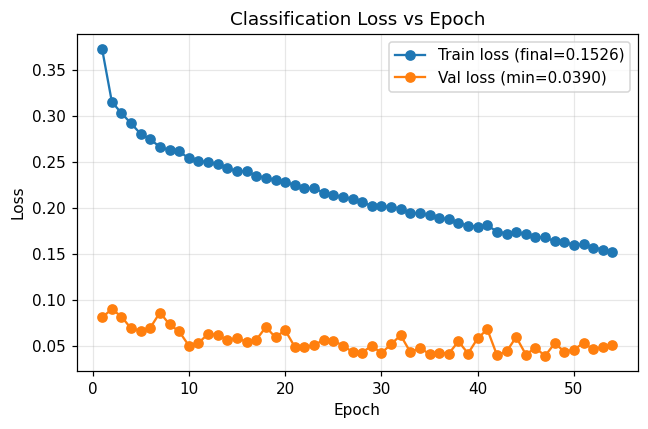

[Info] Saved: ./ConvNeXt+UNet(8,1,1)_base7_Output\curve_loss_train_vs_val.png


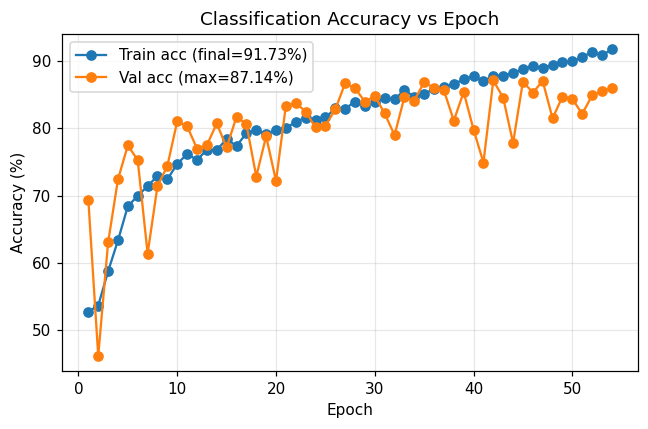

[Info] Saved: ./ConvNeXt+UNet(8,1,1)_base7_Output\curve_acc_train_vs_val.png


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

hist_df = pd.DataFrame(history)
hist_df["epoch"] = np.arange(1, len(hist_df) + 1)

history_csv_path = os.path.join(OUT_DIR, "history_base6.csv")
hist_df.to_csv(history_csv_path, index=False)
print(f"[Info] Saved training history to: {history_csv_path}")

epochs = hist_df["epoch"].values

plt.figure(figsize=(6, 4))
plt.plot(epochs, hist_df["train_loss"], marker="o",
         label=f"Train loss (final={hist_df['train_loss'].iloc[-1]:.4f})")
plt.plot(epochs, hist_df["val_loss"], marker="o",
         label=f"Val loss (min={hist_df['val_loss'].min():.4f})")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Classification Loss vs Epoch")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

loss_fig_path = os.path.join(OUT_DIR, "curve_loss_train_vs_val.png")
plt.savefig(loss_fig_path, dpi=300)
plt.show()
print(f"[Info] Saved: {loss_fig_path}")

plt.figure(figsize=(6, 4))
train_acc_pct = hist_df["train_acc"] * 100.0
val_acc_pct   = hist_df["val_acc"] * 100.0

plt.plot(epochs, train_acc_pct, marker="o",
         label=f"Train acc (final={train_acc_pct.iloc[-1]:.2f}%)")
plt.plot(epochs, val_acc_pct, marker="o",
         label=f"Val acc (max={val_acc_pct.max():.2f}%)")

plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Classification Accuracy vs Epoch")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

acc_fig_path = os.path.join(OUT_DIR, "curve_acc_train_vs_val.png")
plt.savefig(acc_fig_path, dpi=300)
plt.show()
print(f"[Info] Saved: {acc_fig_path}")


[Best model @ Train]
Accuracy (%)        : 88.44
Precision (%)       : 66.721
Recall (%)          : 95.41
F1-Score (%)        : 78.527
Specificity (%)     : 86.457
ROC-AUC (%)         : 96.891
Precision-recall (%): 89.495

[Best model @ Val]
Accuracy (%)        : 85.311
Precision (%)       : 61.719
Recall (%)          : 88.764
F1-Score (%)        : 72.811
Specificity (%)     : 84.328
ROC-AUC (%)         : 92.55
Precision-recall (%): 78.849

[Best model @ Test]
Accuracy (%)        : 84.647
Precision (%)       : 60.622
Recall (%)          : 87.64
F1-Score (%)        : 71.669
Specificity (%)     : 83.795
ROC-AUC (%)         : 92.901
Precision-recall (%): 79.867


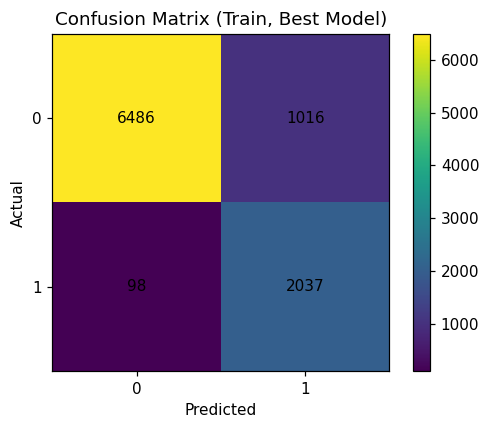

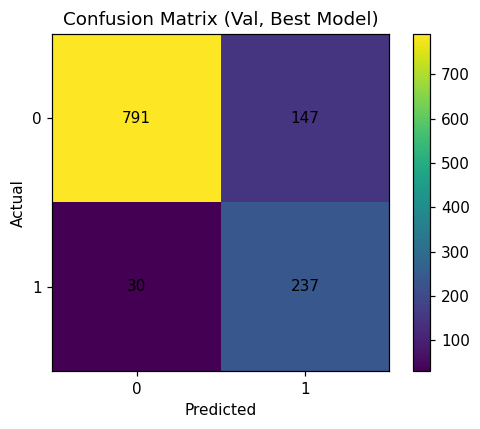

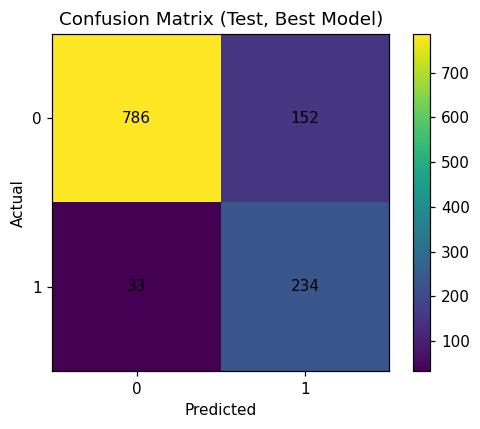

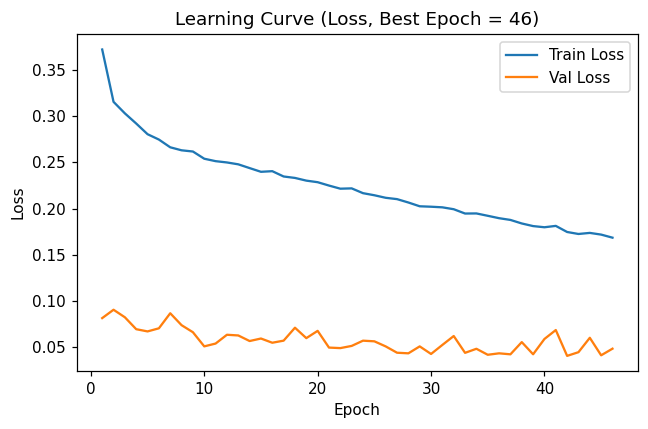

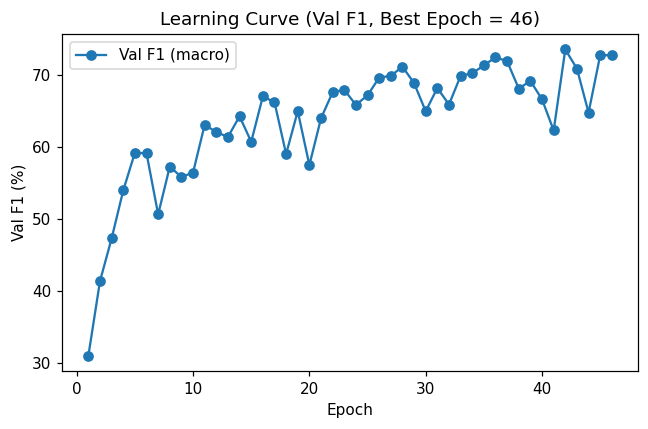

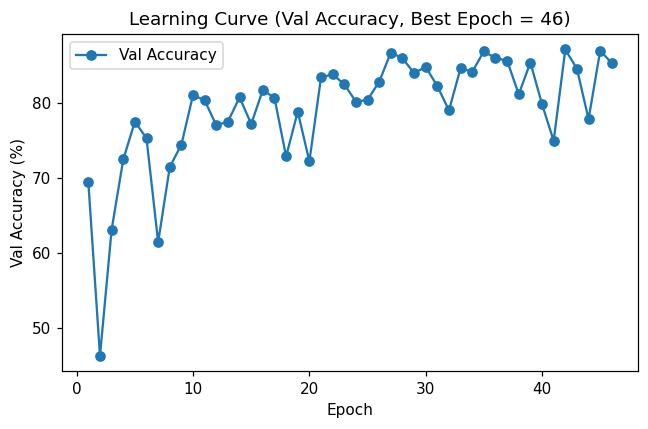

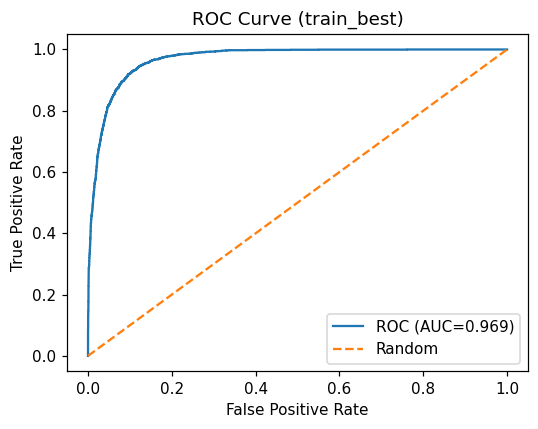

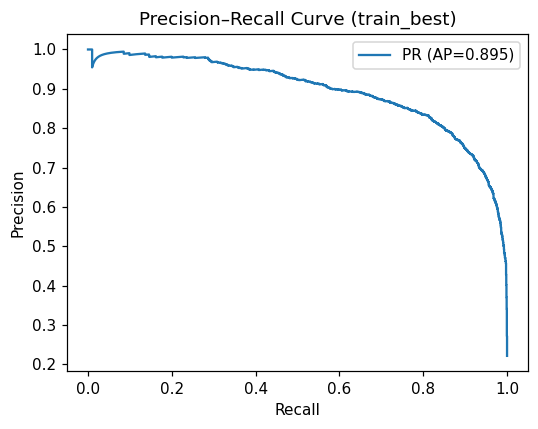

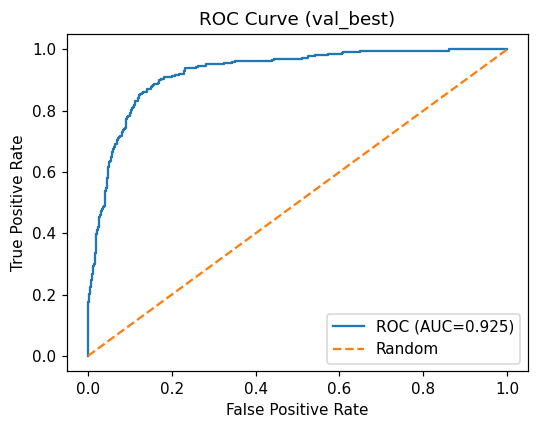

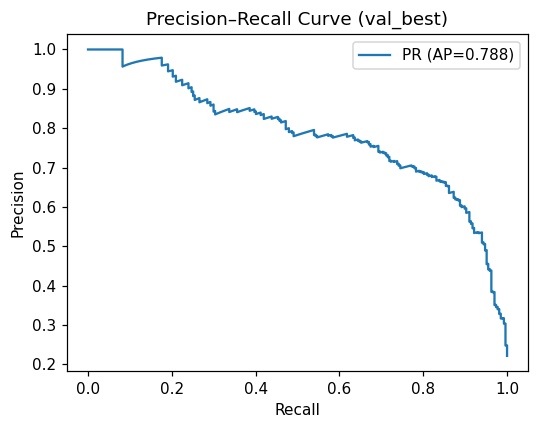

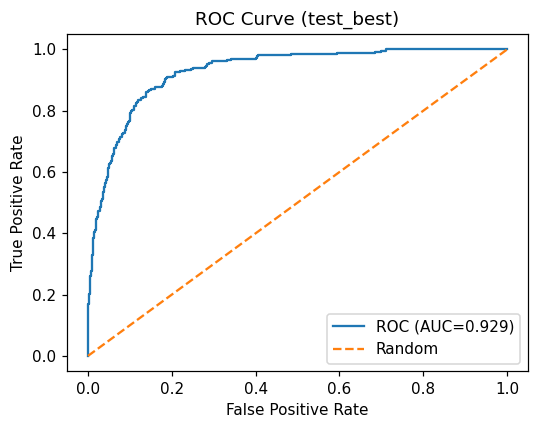

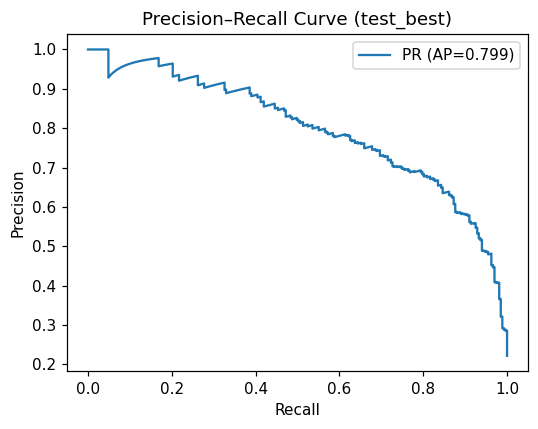

In [27]:
train_metrics_best, ytr_best, ptr_best, str_best = evaluate(model, dl_train_eval, device)
val_metrics_best,   yv_best,  pv_best,  sv_best  = evaluate(model, dl_val,        device)
test_metrics_best,  yt_best,  pt_best,  st_best  = evaluate(model, dl_test,       device)

train_pct = {k: round(v * 100, 3) for k, v in train_metrics_best.items()}
val_pct   = {k: round(v * 100, 3) for k, v in val_metrics_best.items()}
test_pct  = {k: round(v * 100, 3) for k, v in test_metrics_best.items()}

print("\n[Best model @ Train]")
print("Accuracy (%)        :", train_pct["acc"])
print("Precision (%)       :", train_pct["prec"])
print("Recall (%)          :", train_pct["rec"])
print("F1-Score (%)        :", train_pct["f1"])
print("Specificity (%)     :", train_pct["spec"])
print("ROC-AUC (%)         :", train_pct["roc_auc"])
print("Precision-recall (%):", train_pct["pr_auc"])

print("\n[Best model @ Val]")
print("Accuracy (%)        :", val_pct["acc"])
print("Precision (%)       :", val_pct["prec"])
print("Recall (%)          :", val_pct["rec"])
print("F1-Score (%)        :", val_pct["f1"])
print("Specificity (%)     :", val_pct["spec"])
print("ROC-AUC (%)         :", val_pct["roc_auc"])
print("Precision-recall (%):", val_pct["pr_auc"])

print("\n[Best model @ Test]")
print("Accuracy (%)        :", test_pct["acc"])
print("Precision (%)       :", test_pct["prec"])
print("Recall (%)          :", test_pct["rec"])
print("F1-Score (%)        :", test_pct["f1"])
print("Specificity (%)     :", test_pct["spec"])
print("ROC-AUC (%)         :", test_pct["roc_auc"])
print("Precision-recall (%):", test_pct["pr_auc"])

# confusion matrix
plot_confusion_matrix(
    ytr_best, ptr_best,
    out_path=os.path.join(OUT_DIR, "confmat_train_best.png"),
    title="Confusion Matrix (Train, Best Model)"
)

plot_confusion_matrix(
    yv_best, pv_best,
    out_path=os.path.join(OUT_DIR, "confmat_val_best.png"),
    title="Confusion Matrix (Val, Best Model)"
)

plot_confusion_matrix(
    yt_best, pt_best,
    out_path=os.path.join(OUT_DIR, "confmat_test_best.png"),
    title="Confusion Matrix (Test, Best Model)"
)

# learning curves
plot_learning_curves(
    history=history,
    best_epoch=best_epoch,
    out_dir=OUT_DIR,
    prefix="convnextv2_tiny_focal"
)

plot_accuracy_curve(
    history=history,
    best_epoch=best_epoch,
    out_dir=OUT_DIR,
    prefix="convnextv2_tiny_focal"
)

# roc/pr curves
plot_roc_pr(
    y_true=ytr_best,
    y_score=str_best,
    out_dir=OUT_DIR,
    prefix="train_best",
    roc_auc=train_metrics_best["roc_auc"],
    pr_auc=train_metrics_best["pr_auc"]
)

plot_roc_pr(
    y_true=yv_best,
    y_score=sv_best,
    out_dir=OUT_DIR,
    prefix="val_best",
    roc_auc=val_metrics_best["roc_auc"],
    pr_auc=val_metrics_best["pr_auc"]
)

plot_roc_pr(
    y_true=yt_best,
    y_score=st_best,
    out_dir=OUT_DIR,
    prefix="test_best",
    roc_auc=test_metrics_best["roc_auc"],
    pr_auc=test_metrics_best["pr_auc"]
)


##  Train / Val / Test Matrics Comparison

[Debug] metrics_df columns: ['Split', 'acc', 'prec', 'rec', 'f1', 'spec', 'roc_auc', 'pr_auc']
[Info] Saved metrics summary to: ./ConvNeXt+UNet(8,1,1)_base7_Output\metrics_summary_base6.csv


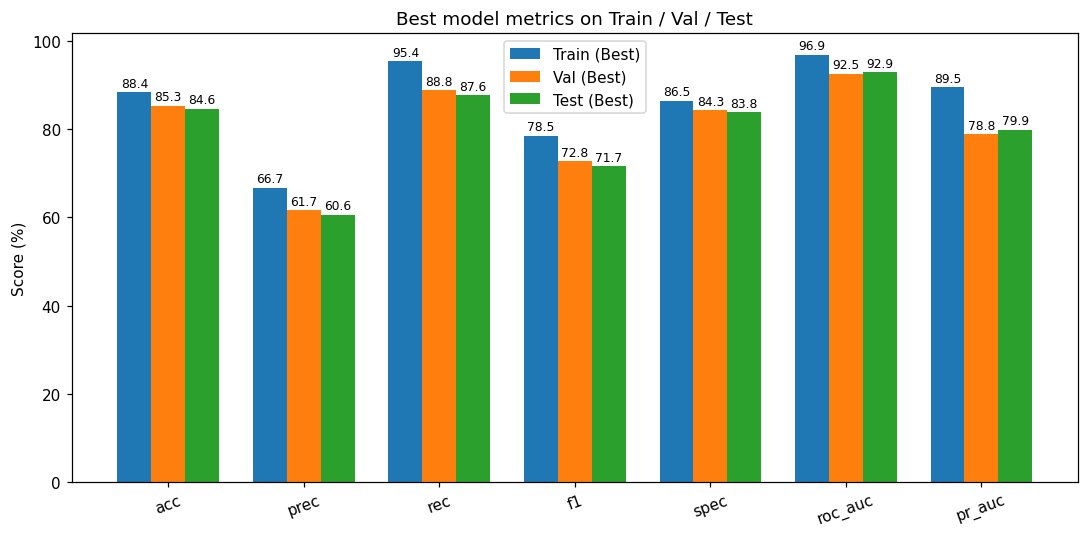

[Info] Saved: ./ConvNeXt+UNet(8,1,1)_base7_Output\metrics_bar_train_val_test_best.png


In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ===== 1. 组装 DataFrame =====
rows = [
    {"Split": "Train (Best)", **train_pct},
    {"Split": "Val (Best)",   **val_pct},
    {"Split": "Test (Best)",  **test_pct},
]

metrics_df = pd.DataFrame(rows)

# 把 Split 放到第一列，其他指标列保持原来的顺序
metric_cols = [c for c in metrics_df.columns if c != "Split"]
metrics_df = metrics_df[["Split"] + metric_cols]

print("[Debug] metrics_df columns:", list(metrics_df.columns))

# 保存 CSV
metrics_csv_path = os.path.join(OUT_DIR, "metrics_summary_base6.csv")
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"[Info] Saved metrics summary to: {metrics_csv_path}")

# ===== 2. 画柱状图：Train / Val / Test 指标对比 =====
x = np.arange(len(metric_cols))  # 每个指标一个 x 位置
width = 0.25                     # 每个 split 的柱宽

plt.figure(figsize=(10, 5))

for i, split in enumerate(metrics_df["Split"]):
    values = metrics_df.loc[i, metric_cols].values.astype(float)
    offset = (i - 1) * width  # -width, 0, +width 三组
    bars = plt.bar(x + offset, values, width, label=split)

    # 在柱子顶上标具体数值
    for xi, v in zip(x + offset, values):
        plt.text(xi, v + 0.5, f"{v:.1f}",
                 ha="center", va="bottom", fontsize=8)

# x 轴标签稍微清洗一下：去掉 (%) 之类
xtick_labels = [
    c.replace("(%)", "").replace("%", "").strip()
    for c in metric_cols
]

plt.xticks(x, xtick_labels, rotation=20)
plt.ylabel("Score (%)")
plt.title("Best model metrics on Train / Val / Test")
plt.legend()
plt.tight_layout()

bar_fig_path = os.path.join(OUT_DIR, "metrics_bar_train_val_test_best.png")
plt.savefig(bar_fig_path, dpi=300)
plt.show()
print(f"[Info] Saved: {bar_fig_path}")



=== Top 10 thresholds on val (sorted by f1) ===
threshold    acc   prec    rec     f1   spec
    0.532 86.556 64.789 86.142 73.955 86.674
    0.584 87.386 68.977 78.277 73.333 89.979
    0.480 84.481 60.000 89.888 71.964 82.942
    0.637 87.884 73.913 70.037 71.923 92.964
    0.428 80.996 54.185 92.135 68.239 77.825
    0.689 86.971 78.351 56.929 65.944 95.522
    0.376 77.759 49.901 94.757 65.375 72.921
    0.323 72.780 44.658 95.506 60.859 66.311
    0.741 85.477 82.394 43.820 57.213 97.335
    0.271 65.892 39.058 96.255 55.568 57.249

Best threshold on validation set (by f1):
t = 0.532, Acc=86.556%, Prec=64.789%, Rec=86.142%, F1=73.955%, Spec=86.674%


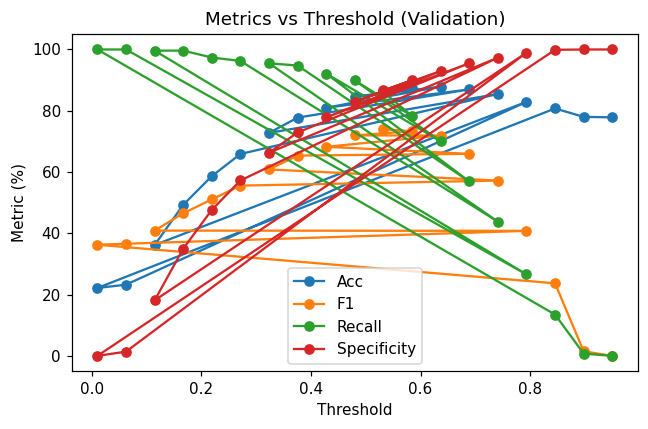


>>> The best threshold on validation set: best_t = 0.532

[Best threshold model @ Test (t=0.532)]
Accuracy (%)        : 86.390
Precision (%)       : 64.756
Recall (%)          : 84.644
F1-Score (%)        : 73.377
Specificity (%)     : 86.887
ROC-AUC (%)         : 92.901
Precision-recall (%): 79.867

[Best threshold model @ Val (t=0.532)]
Accuracy (%)        : 86.556
Precision (%)       : 64.789
Recall (%)          : 86.142
F1-Score (%)        : 73.955


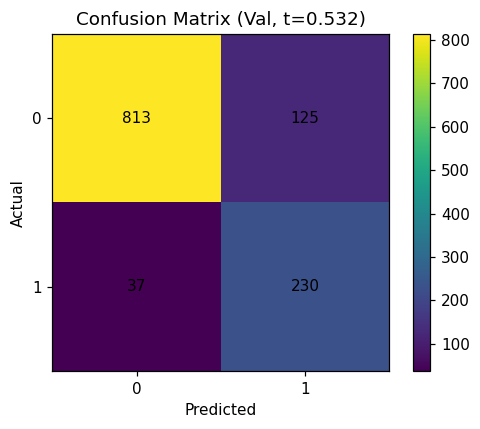

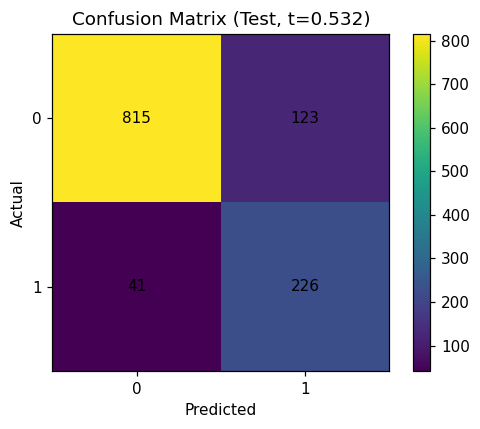

In [29]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score
)

def sweep_thresholds(y_true, y_score, thresholds=None, sort_by="f1", verbose=True):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_score = np.asarray(y_score).ravel()

    if thresholds is None:
        thresholds = np.linspace(0.01, 0.95, 19)

    results = []
    for t in thresholds:
        y_pred = (y_score >= t).astype(int)

        acc  = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)

        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp + 1e-8)
        else:
            spec = float("nan")

        results.append({
            "threshold": t,
            "acc": acc,
            "prec": prec,
            "rec": rec,
            "f1": f1,
            "spec": spec,
        })

    df_thr = pd.DataFrame(results)
    df_thr_sorted = df_thr.sort_values(sort_by, ascending=False).reset_index(drop=True)

    if verbose:
        print(f"\n=== Top 10 thresholds on val (sorted by {sort_by}) ===")
        tmp = df_thr_sorted.copy()
        for col in ["acc", "prec", "rec", "f1", "spec"]:
            tmp[col] = tmp[col] * 100.0
        print(tmp.head(10).to_string(index=False, 
                                     formatters={"threshold": "{:.3f}".format,
                                                 "acc": "{:.3f}".format,
                                                 "prec": "{:.3f}".format,
                                                 "rec": "{:.3f}".format,
                                                 "f1": "{:.3f}".format,
                                                 "spec": "{:.3f}".format}))

        best_row = df_thr_sorted.iloc[0]
        print("\nBest threshold on validation set (by {}):".format(sort_by))
        print(
            f"t = {best_row['threshold']:.3f}, "
            f"Acc={best_row['acc']*100:.3f}%, "
            f"Prec={best_row['prec']*100:.3f}%, "
            f"Rec={best_row['rec']*100:.3f}%, "
            f"F1={best_row['f1']*100:.3f}%, "
            f"Spec={best_row['spec']*100:.3f}%"
        )

    return df_thr_sorted

def plot_threshold_metrics(df_thr, out_dir, prefix="val_thr"):
    os.makedirs(out_dir, exist_ok=True)

    thr = df_thr["threshold"].values

    plt.figure(figsize=(6,4))
    for key, label in [
        ("acc",  "Acc"),
        ("f1",   "F1"),
        ("rec",  "Recall"),
        ("spec", "Specificity"),
    ]:
        if key in df_thr.columns:
            plt.plot(thr, df_thr[key].values * 100.0, marker="o", label=label)

    plt.xlabel("Threshold")
    plt.ylabel("Metric (%)")
    plt.title("Metrics vs Threshold (Validation)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_metrics_vs_threshold.png"), dpi=300)
    plt.show()


df_thr_val = sweep_thresholds(yv_best, sv_best, sort_by="f1", verbose=True)
plot_threshold_metrics(df_thr_val, OUT_DIR, prefix="val_thr")

best_t = df_thr_val.iloc[0]["threshold"]
print(f"\n>>> The best threshold on validation set: best_t = {best_t:.3f}")

yt = np.asarray(yt_best).astype(int).ravel()
st = np.asarray(st_best).ravel()

y_test_pred = (st >= best_t).astype(int)

test_acc  = accuracy_score(yt, y_test_pred)
test_prec = precision_score(yt, y_test_pred, zero_division=0)
test_rec  = recall_score(yt, y_test_pred, zero_division=0)
test_f1   = f1_score(yt, y_test_pred, zero_division=0)

cm_test = confusion_matrix(yt, y_test_pred)
if cm_test.shape == (2, 2):
    tn, fp, fn, tp = cm_test.ravel()
    test_spec = tn / (tn + fp + 1e-8)
else:
    test_spec = float("nan")

test_roc = roc_auc_score(yt, st)
test_pr  = average_precision_score(yt, st)

print(f"\n[Best threshold model @ Test (t={best_t:.3f})]")
print(f"Accuracy (%)        : {test_acc*100:.3f}")
print(f"Precision (%)       : {test_prec*100:.3f}")
print(f"Recall (%)          : {test_rec*100:.3f}")
print(f"F1-Score (%)        : {test_f1*100:.3f}")
print(f"Specificity (%)     : {test_spec*100:.3f}")
print(f"ROC-AUC (%)         : {test_roc*100:.3f}")
print(f"Precision-recall (%): {test_pr*100:.3f}")

y_val_pred = (np.asarray(sv_best) >= best_t).astype(int)
val_acc2  = accuracy_score(yv_best, y_val_pred)
val_prec2 = precision_score(yv_best, y_val_pred, zero_division=0)
val_rec2  = recall_score(yv_best, y_val_pred, zero_division=0)
val_f12   = f1_score(yv_best, y_val_pred, zero_division=0)

print(f"\n[Best threshold model @ Val (t={best_t:.3f})]")
print(f"Accuracy (%)        : {val_acc2*100:.3f}")
print(f"Precision (%)       : {val_prec2*100:.3f}")
print(f"Recall (%)          : {val_rec2*100:.3f}")
print(f"F1-Score (%)        : {val_f12*100:.3f}")

# --- Confusion matrix at best threshold ---

# Val
plot_confusion_matrix(
    y_true=yv_best,
    y_pred=y_val_pred,
    out_path=os.path.join(OUT_DIR, f"confmat_val_best_t_{best_t:.3f}.png"),
    title=f"Confusion Matrix (Val, t={best_t:.3f})"
)

# Test
plot_confusion_matrix(
    y_true=yt,
    y_pred=y_test_pred,
    out_path=os.path.join(OUT_DIR, f"confmat_test_best_t_{best_t:.3f}.png"),
    title=f"Confusion Matrix (Test, t={best_t:.3f})"
)

In [30]:
import pandas as pd

rows = [
    {
        "Split": "Train (Best)",
        "Accuracy (%)":         train_pct["acc"],
        "Precision (%)":        train_pct["prec"],
        "Recall (%)":           train_pct["rec"],
        "F1-Score (%)":         train_pct["f1"],
        "Specificity (%)":      train_pct["spec"],
        "ROC-AUC (%)":          train_pct["roc_auc"],
        "Precision-recall (%)": train_pct["pr_auc"],
    },
    {
        "Split": "Val (Best)",
        "Accuracy (%)":         val_pct["acc"],
        "Precision (%)":        val_pct["prec"],
        "Recall (%)":           val_pct["rec"],
        "F1-Score (%)":         val_pct["f1"],
        "Specificity (%)":      val_pct["spec"],
        "ROC-AUC (%)":          val_pct["roc_auc"],
        "Precision-recall (%)": val_pct["pr_auc"],
    },
    {
        "Split": "Test (Best)",
        "Accuracy (%)":         test_pct["acc"],
        "Precision (%)":        test_pct["prec"],
        "Recall (%)":           test_pct["rec"],
        "F1-Score (%)":         test_pct["f1"],
        "Specificity (%)":      test_pct["spec"],
        "ROC-AUC (%)":          test_pct["roc_auc"],
        "Precision-recall (%)": test_pct["pr_auc"],
    },
]

df_best = pd.DataFrame(rows)
print(df_best)

df_best.to_csv(os.path.join(OUT_DIR, "best_train_val_test_metrics_convnextv2.csv"), index=False, mode="w")


          Split  Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)  \
0  Train (Best)        88.440         66.721      95.410        78.527   
1    Val (Best)        85.311         61.719      88.764        72.811   
2   Test (Best)        84.647         60.622      87.640        71.669   

   Specificity (%)  ROC-AUC (%)  Precision-recall (%)  
0           86.457       96.891                89.495  
1           84.328       92.550                78.849  
2           83.795       92.901                79.867  
